# Exploratory data analysis of Hateful Discussions dataset from https://github.com/liamhebert/MultiModalDiscussionTransformer/tree/main

### Set up 

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import json
import seaborn as sns

#### Generate graph of conversation 

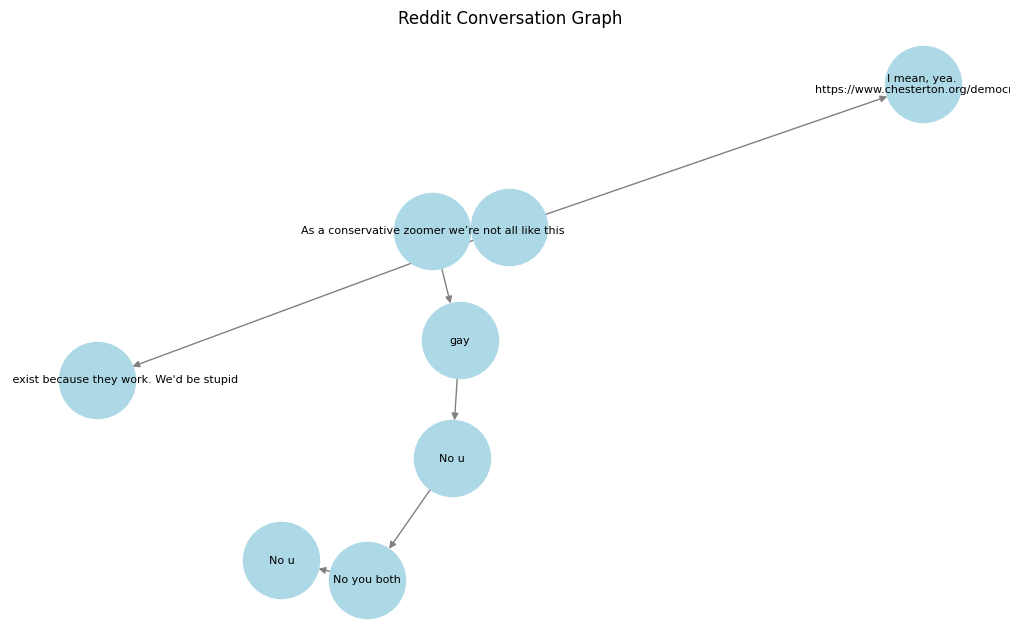

In [126]:
import json
import networkx as nx
import matplotlib.pyplot as plt

def load_jsonl(file_path):
    """Load JSONL file and return a list of parsed JSON objects."""
    with open(file_path, "r", encoding="utf-8") as f:
        return [json.loads(line)[0] for i, line in enumerate(f) if i > 0]

def build_graph(data):
    """Create a directed graph from Reddit-style conversations."""
    G = nx.DiGraph()
    node_labels = {}

    for entry in data:
        node_id = entry["id"]
        parent_id = entry["parent_id"]
        text = entry["body"] if entry["body"] else entry["selftext"]

        # Add node with text as label
        G.add_node(node_id, label=text[:50])  # Limit text length for readability
        node_labels[node_id] = text[:50]  # Store labels separately

        # Add edge from parent to child if parent exists
        if parent_id and parent_id in G:
            G.add_edge(parent_id, node_id)

    return G, node_labels

def draw_graph(G, node_labels):
    """Draw the conversation graph."""
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color="lightblue", edge_color="gray", node_size=3000, font_size=8)
    plt.title("Reddit Conversation Graph")
    plt.show()

# Load data from JSONL file
file_path = "../../data/examples/graph-5419.jsonl"  
data = load_jsonl(file_path)

# Build and visualize the graph
G, node_labels = build_graph(data)
draw_graph(G, node_labels)


#### Trim graph

/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_43941/1729408325.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(input_file)


True index: 7
ID: enf0wf2
Text: Cheeeeeeeap flight tickets in Macao.
Number of comments kept in conversation: 8
texts:  ['', 'I mean, yea. \nhttps://www.chesterton.org/democracy-of-the-dead/', 'Traditions exist because they work. We\'d be stupid to throw away what had helped keep our ancestors alive simply because "oH tHey\'RE dEAd". When you become rootless, other things begin to fill that void. Responsibility and hard work had been torn up, to be replaced with decadence and passive acceptance.', 'As a conservative zoomer we’re not all like this', 'gay', 'No u', 'No you both', 'No u']


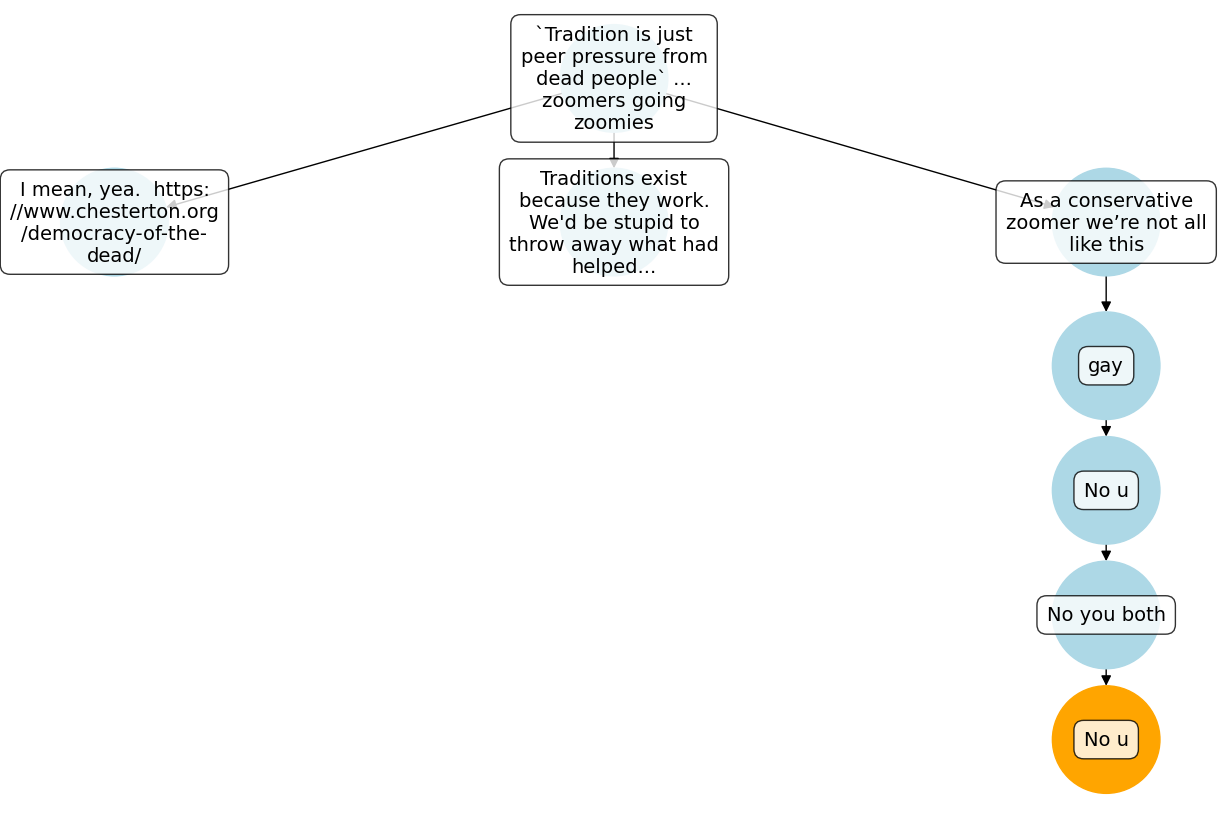

In [129]:
import sys
import os

# Add the directory to sys.path
sys.path.append("../utils")
from construct_graph import get_graph

def load_and_trim_graph(input_file):
    try:
        # Load the .pt file
        data = torch.load(input_file)
        mask = data["y_mask"]
        true_index = [i for i in range(len(mask)) if mask[i] == True]
        assert len(true_index) == 1
        true_index = true_index[0]
        comment = graph.x_text[true_index]
        my_id = comment[0]['id']
        my_text = comment[0]['body'] #if comment[0]["body"] else comment[0]["selftext"]
        print(f"True index: {true_index}")
        print(f"ID: {my_id}")
        print(f"Text: {my_text}")

        _, edges_dic_num, conv_indices_to_keep, my_new_mask_idx = get_graph(data.x_text, mask, with_temporal_edges=False, undirected=False)
        assert len(edges_dic_num.keys()) <= 1, "length of edges dic num is greater than 1"
        edge_list = []
        for k in edges_dic_num.keys():
            edge_list = edges_dic_num[k]
            edge_list = sorted(edge_list, key=lambda x: (x[0], x[1]))
            edge_list = torch.tensor(edge_list)
        x = data.x
        y = data.y

        texts = []
        vertices_kept = []
        for i in conv_indices_to_keep:
            vertices_kept.append(data.x_text[i][0])
            texts.append(data.x_text[i][0]['body'])
        print(f"Number of comments kept in conversation: {len(conv_indices_to_keep)}")
        print("texts: ", texts)
        return vertices_kept, edge_list

    except Exception as e:
        print(f"Error loading file {input_file}: {e}")
        return None

def build_graph(vertices_kept, edge_list):
    """Create a directed graph from Reddit-style conversations."""
    G = nx.DiGraph()
    node_labels = {}

    for i, entry in enumerate(vertices_kept):
        node_id = entry["id"]
        parent_id = entry["parent_id"]
        text = entry["body"] if entry["body"] else entry["selftext"]
        if i == 0:
            text = "`Tradition is just peer pressure from dead people` ... zoomers going zoomies"

        # Add node with text as label
        G.add_node(node_id, label=text)  # Limit text length for readability
        node_labels[node_id] = text  # Store labels separately

        # Add edge from parent to child if parent exists
        if parent_id and parent_id in G:
            G.add_edge(parent_id, node_id)

    return G, node_labels

def draw_graph(G, node_labels):
    """Draw the conversation graph."""
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
    # Last node to be yellow
    last_node = list(G.nodes())[-1]
    node_colors = ["yellow" if node == last_node else "lightblue" for node in G.nodes()]
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, edge_color="gray", node_size=3000, font_size=8)
    plt.title("Reddit Conversation Graph")
    plt.show()

# Load data from JSONL file
# 162, 329, 629, 1105, 1134, 1301, 1517, 2199, 3069 ...
file_path = "../../data/balanced_cad/processed/graph-5419.pt"  
vertices, edge_list = load_and_trim_graph(file_path)

# Build and visualize the graph
G, node_labels = build_graph(vertices, edge_list)

def wrap_text(text, width=20):
    """Wrap text into multiple lines for better readability."""
    return "\n".join(textwrap.wrap(text, width))

# Ensure node_labels is created from the graph's 'label' attribute and wrapped
node_labels = {node: wrap_text(G.nodes[node].get("label", str(node))) for node in G.nodes()}

# Layout using Graphviz's dot (hierarchical top-down)
pos = graphviz_layout(G, prog="dot")

# Draw the graph (without labels, to add them separately)
plt.figure(figsize=(12, 8))

# Identify the last node added (by order of insertion)
last_node = list(G.nodes())[-1] 
node_colors = ["#FFA500" if node == last_node else "#ADD8E6" for node in G.nodes()]   
#node_colors = ["#FFA500" if node == last_node else "lightblue" for node in G.nodes()]
    
trimmed_labels = {node: (label[:80] + "..." if len(label) > 100 else label) for node, label in node_labels.items()}

nx.draw(G, pos, node_size=6000, node_color=node_colors, edge_color="black",
        linewidths=1, arrows=True, arrowsize=15, font_size=16, font_family="Times New Roman")

# Add text labels centered on nodes
for node, (x, y) in pos.items():
    plt.text(x, y, trimmed_labels[node], fontsize=14, ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8))

# Save as high-quality PDF
plt.savefig("gdiagrams/graph-5419.pdf", format="pdf", bbox_inches="tight")
plt.show()



/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_43941/3568663181.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(input_file)


texts:  ['', 'I mean, yea. \nhttps://www.chesterton.org/democracy-of-the-dead/', 'Traditions exist because they work. We\'d be stupid to throw away what had helped keep our ancestors alive simply because "oH tHey\'RE dEAd". When you become rootless, other things begin to fill that void. Responsibility and hard work had been torn up, to be replaced with decadence and passive acceptance.', 'As a conservative zoomer we’re not all like this', 'gay', 'No u', 'No you both', 'No u']
7


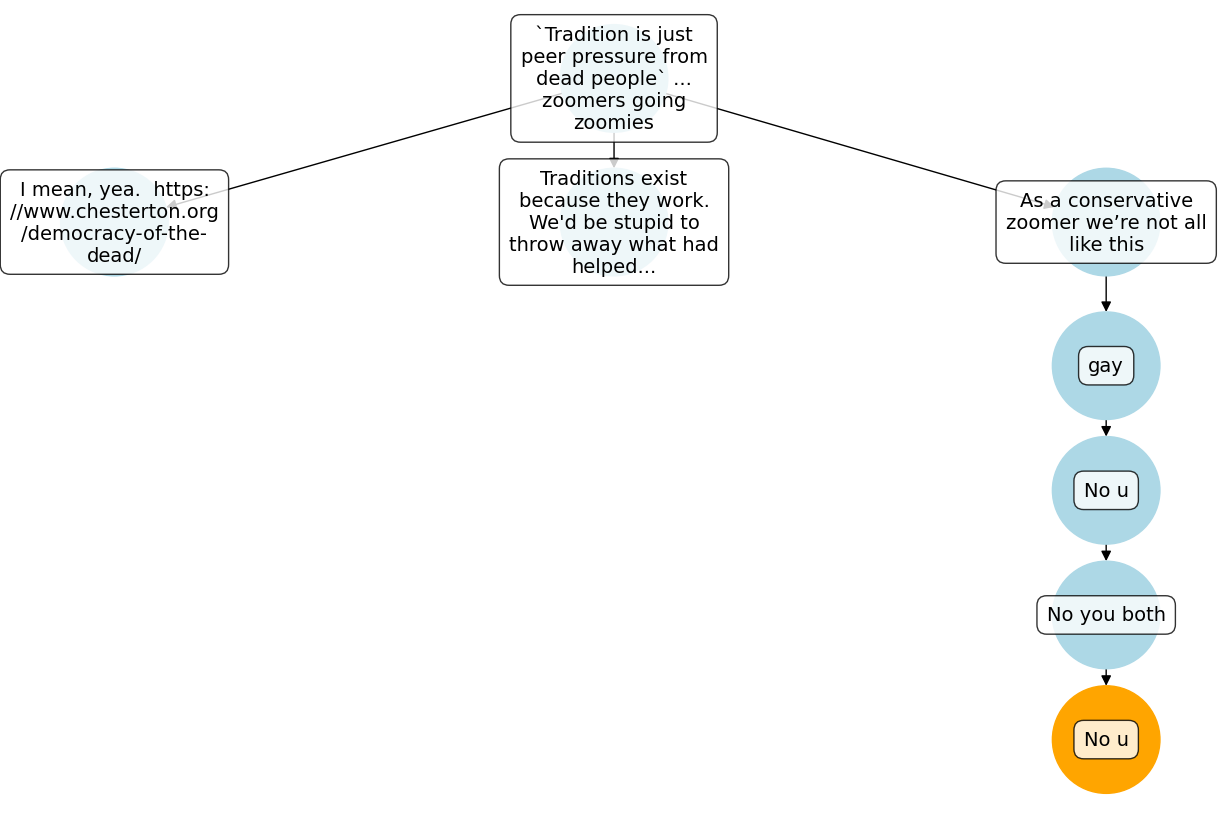

In [131]:
import sys
import os

# Add the directory to sys.path
sys.path.append("../utils")
from construct_graph import get_graph

def load_and_trim_graph(input_file):
    try:
        # Load the .pt file
        data = torch.load(input_file)
        mask = data["y_mask"]
        true_index = [i for i in range(len(mask)) if mask[i] == True]
        assert len(true_index) == 1
        true_index = true_index[0]

        x = data.x
        y = data.y

        texts = []
        vertices_kept = []
        for comment in data.x_text:
            body_text = comment[0]['body']
            vertices_kept.append(comment[0])
            texts.append(body_text)
        print("texts: ", texts)
        return vertices_kept, true_index

    except Exception as e:
        print(f"Error loading file {input_file}: {e}")
        return None

def build_graph(vertices_kept, edge_list):
    """Create a directed graph from Reddit-style conversations."""
    G = nx.DiGraph()
    node_labels = {}

    for i, entry in enumerate(vertices_kept):
        node_id = entry["id"]
        parent_id = entry["parent_id"]
        text = entry["body"] if entry["body"] else entry["selftext"]
        if i == 0:
            text = "`Tradition is just peer pressure from dead people` ... zoomers going zoomies"

        # Add node with text as label
        G.add_node(node_id, label=text)  # Limit text length for readability
        node_labels[node_id] = text  # Store labels separately

        # Add edge from parent to child if parent exists
        if parent_id and parent_id in G:
            G.add_edge(parent_id, node_id)

    return G, node_labels

def draw_graph(G, node_labels):
    """Draw the conversation graph."""
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
    # Last node to be yellow
    last_node = list(G.nodes())[-1]
    node_colors = ["yellow" if node == last_node else "lightblue" for node in G.nodes()]
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, edge_color="gray", node_size=3000, font_size=8)
    plt.title("Reddit Conversation Graph")
    plt.show()

# Load data from JSONL file
# 162, 329, 629, 1105, 1134, 1301, 1517, 2199, 3069 ...
file_path = "../../data/balanced_cad/processed/graph-5419.pt"  
vertices, true_index = load_and_trim_graph(file_path)
print(true_index)

# Build and visualize the graph
G, node_labels = build_graph(vertices, edge_list)

def wrap_text(text, width=20):
    """Wrap text into multiple lines for better readability."""
    return "\n".join(textwrap.wrap(text, width))

# Ensure node_labels is created from the graph's 'label' attribute and wrapped
node_labels = {node: wrap_text(G.nodes[node].get("label", str(node))) for node in G.nodes()}

# Layout using Graphviz's dot (hierarchical top-down)
pos = graphviz_layout(G, prog="dot")

# Draw the graph (without labels, to add them separately)
plt.figure(figsize=(12, 8))

# Identify the last node added (by order of insertion)
last_node = list(G.nodes())[true_index] 
node_colors = ["#FFA500" if node == last_node else "#ADD8E6" for node in G.nodes()]   
#node_colors = ["#FFA500" if node == last_node else "lightblue" for node in G.nodes()]
    
trimmed_labels = {node: (label[:80] + "..." if len(label) > 100 else label) for node, label in node_labels.items()}

nx.draw(G, pos, node_size=6000, node_color=node_colors, edge_color="black",
        linewidths=1, arrows=True, arrowsize=15, font_size=16, font_family="Times New Roman")

# Add text labels centered on nodes
for node, (x, y) in pos.items():
    plt.text(x, y, trimmed_labels[node], fontsize=14, ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8))

# Save as high-quality PDF
plt.savefig("gdiagrams/graph-full-5419.pdf", format="pdf", bbox_inches="tight")
plt.show()



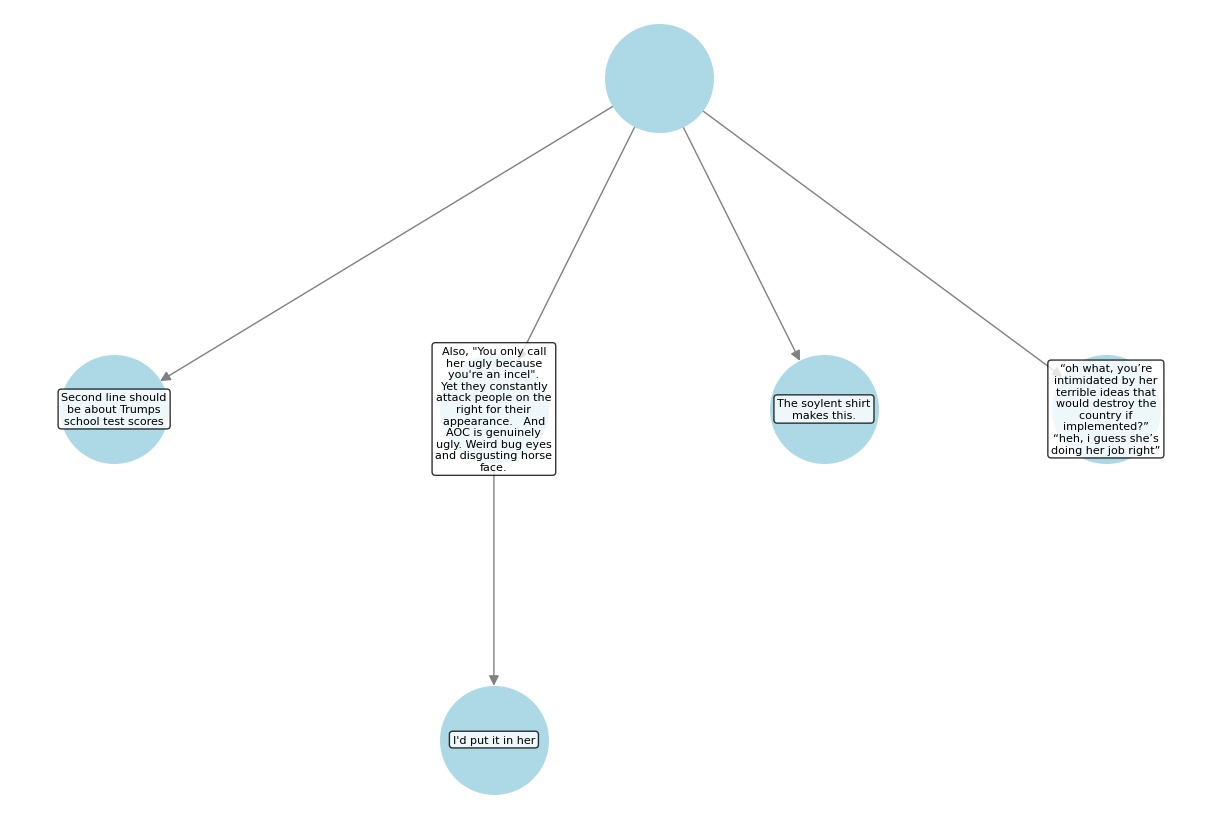

In [97]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import textwrap

def wrap_text(text, width=20):
    """Wrap text into multiple lines for better readability."""
    return "\n".join(textwrap.wrap(text, width))

# Ensure node_labels is created from the graph's 'label' attribute and wrapped
node_labels = {node: wrap_text(G.nodes[node].get("label", str(node))) for node in G.nodes()}

# Layout using Graphviz's dot (hierarchical top-down)
pos = graphviz_layout(G, prog="dot")

# Draw the graph (without labels, to add them separately)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, node_size=6000, node_color="lightblue", edge_color="gray",
        linewidths=1, arrows=True, arrowsize=15)

# Add text labels centered on nodes
for node, (x, y) in pos.items():
    plt.text(x, y, node_labels[node], fontsize=8, ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.8))

# Save as high-quality PDF
plt.savefig("gdiagrams/graph-2329.pdf", format="pdf", bbox_inches="tight")
plt.show()



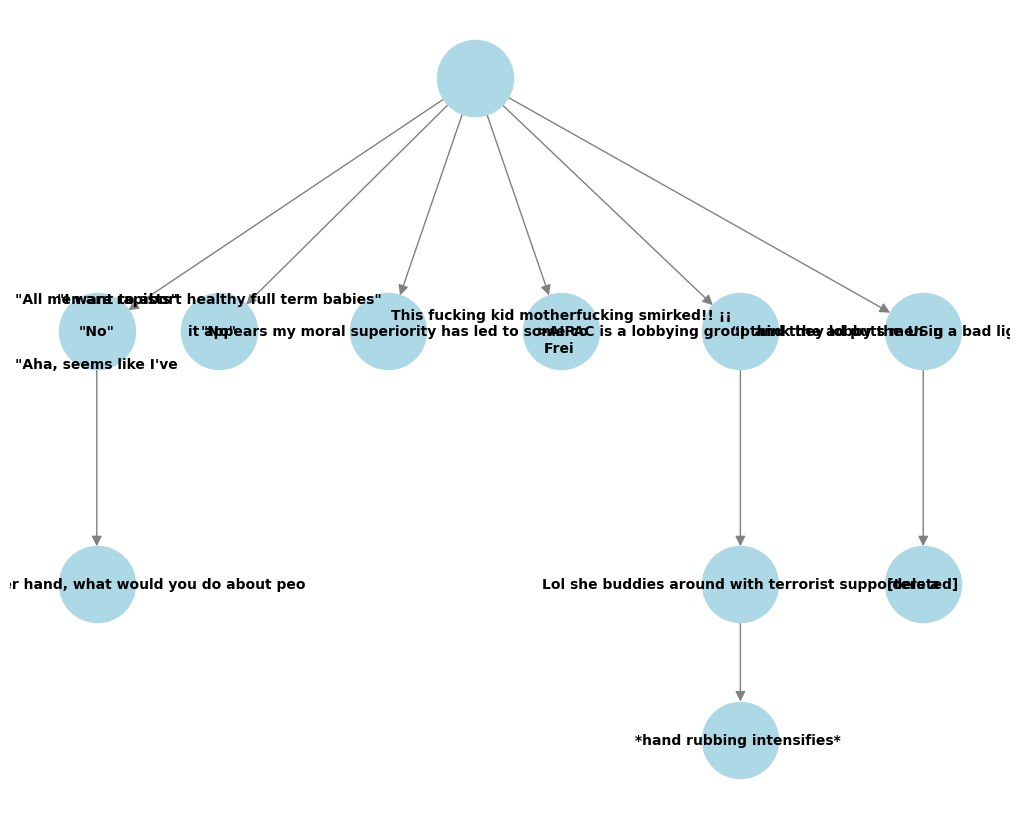

In [53]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

# Ensure node_labels is created from the graph's 'label' attribute
node_labels = {node: G.nodes[node].get("label", str(node)) for node in G.nodes()}

# Layout using Graphviz's dot (hierarchical top-down)
pos = graphviz_layout(G, prog="dot")

# Draw the graph with text labels
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=3000, 
        node_color="lightblue", edge_color="gray", linewidths=1, 
        font_size=10, font_weight="bold", arrows=True, arrowsize=15)

# Save as high-quality PDF
plt.savefig("graph_diagram.pdf", format="pdf", bbox_inches="tight")
plt.show()


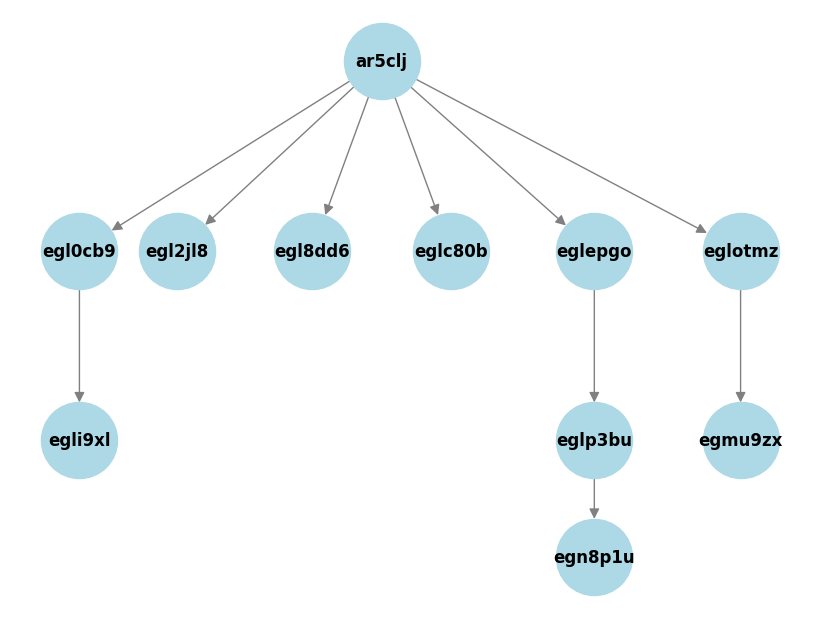

In [52]:

import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

node_labels = {node: G.nodes[node].get("text", str(node)) for node in G.nodes()}


# Layout using Graphviz's dot (hierarchical top-down)
pos = graphviz_layout(G, prog="dot")

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", 
        edge_color="gray", linewidths=1, font_size=12, font_weight="bold", 
        arrows=True, arrowsize=15)

# Save as high-quality PDF
plt.savefig("graph_diagram.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [12]:
import json
import csv
import os

input_dir = "../../data/sample-reanno/"
output_file = "../../data/sample-reanno/eval_set_output.csv"

# Prepare the CSV file
with open(output_file, mode='w', newline='', encoding='utf-8') as csv_file:
    fieldnames = ['filename', 'reddit_url', 'index', 'label', 'anno_ctx', 'anno_tgt', 'anno_tgt_cat', 'body']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    
    # Loop over the files
    for _, i in enumerate(indices):
        filename = f"graph-{i}.jsonl"
        filepath = os.path.join(input_dir, filename)
        if not os.path.exists(filepath):
            print(f"File {filepath} does not exist.")
            continue
        
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                if not lines:
                    print(f"No content in file {filepath}")
                    continue
                
                # First line is the index label
                index_label_line = lines[0].strip()
                index_label = int(index_label_line)
                
                # Remaining lines are JSON entries
                json_entries = []
                for line in lines[1:]:
                    json_entry = json.loads(line.strip())
                    json_entries.append(json_entry)
                
                if index_label >= len(json_entries):
                    print(f"Index label {index_label} out of range in file {filepath}")
                    continue
                
                selected_entry = json_entries[index_label]
                
                # Extract required fields
                node_data = selected_entry[0]  # The first element of the list is the node data dict
                
                permalink = node_data.get('permalink', '')
                reddit_url = 'https://www.reddit.com' + permalink
                
                label = node_data.get('label', '')
                anno_ctx = node_data.get('anno_ctx', '')
                anno_tgt = node_data.get('anno_tgt', '')
                anno_tgt_cat = node_data.get('anno_tgt_cat', '')
                body = node_data.get('body', '')
                
                # Write to CSV
                writer.writerow({
                    'filename': filename,
                    'reddit_url': reddit_url,
                    'index': index_label,
                    'label': label,
                    'anno_ctx': anno_ctx,
                    'anno_tgt': anno_tgt,
                    'anno_tgt_cat': anno_tgt_cat,
                    'body': body
                })
                
        except Exception as e:
            print(f"Error processing file {filepath}: {e}")


In [ ]:
input_dir = "../../data/"
output_file = "../../data/false_positives_model.jsonl"

def error_analysis(input_file, output_file, error_type='fp'):
    assert error_type in ['fp', 'fn', 'all']
    with open(input_file, 'r', encoding='utf-8') as tsv_file, open(output_file, 'w', encoding='utf-8') as jsonl_file:
        # Read the first line to extract headers
        headers = ['pred_label', 'y_pred', 'y', 'text',	'conv_indices',	'texts']

        for line in tsv_file:
            # Skip empty lines
            if not line.strip():
                continue

            # Split the line into values and create a dictionary
            values = line.strip().split('\t')
            record = {headers[i]: values[i] for i in range(len(headers))}

            # Write the dictionary as a JSON object to the JSONL file
            json.dump(record, jsonl_file)
            jsonl_file.write('\n')

        
        # Loop over the files
        for _, i in enumerate(indices):
            filename = f"graph-{i}.jsonl"
            filepath = os.path.join(input_dir, filename)
            if not os.path.exists(filepath):
                print(f"File {filepath} does not exist.")
                continue
            
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    lines = f.readlines()
                    if not lines:
                        print(f"No content in file {filepath}")
                        continue

In [90]:
postx, _, _, postlab = a.x_text[0]
postx['id']

'6xblvu'

In [7]:
def populate_keys(in_dict, out_dict, keys, suffix=""):
    for k in keys:
        out_dict[suffix + k] = in_dict[k] if k in in_dict.keys() else ""
    return out_dict


def collect_data_from_conv(a):
    # a is dict with keys ['x', 'x_text', 'y_mask', 'edge_index', 'distance_matrix', 'x_images', 'y', 'x_image_index']
    output_data = {}
    output_data["true_binary_label"] = a['y'].item()
    true_index = [i for i in range(len(a.y_mask)) if a.y_mask[i] == True]
    assert len(true_index) == 1
    true_index = true_index[0]
    output_data["index_in_conv"] = true_index
    output_data["length_conv"] = len(a.y_mask)
    

    comment = a['x_text'][true_index]
    x, a2, a3, label = comment
    # x is a dict with keys: 'author', 'author_flair_css_class', 'author_flair_text', 'body', 'can_gild', 'collapsed', 'collapsed_reason', 'controversiality', 'created_utc', 'distinguished', 'edited', 'gilded', 'id', 'is_submitter', 'link_id', 'parent_id', 'retrieved_on', 'score', 'stickied', 'subreddit', 'subreddit_id', 'label'])

    #print(x.keys())
    output_data = populate_keys(x, output_data, ["author", "body", "controversiality", "subreddit", "label", "score", "parent_id", "id", "created_utc", "edited"], suffix="")

    x_post, _, _, label_post = a['x_text'][0]
    # label_post is NA

    # x_post is a dict with keys: []'archived', 'author', 'author_flair_css_class', 'author_flair_text', 'brand_safe', 'contest_mode', 'created_utc', 'distinguished', 'domain', 'edited', 'gilded', 'hidden', 'hide_score', 'id', 'is_crosspostable', 'is_reddit_media_domain', 'is_self', 'is_video', 'link_flair_css_class', 'link_flair_text', 'locked', 'media', 'media_embed', 'num_comments', 'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'post_hint', 'preview', 'retrieved_on', 'score', 'secure_media', 'secure_media_embed', 'selftext', 'spoiler', 'stickied', 'subreddit', 'subreddit_id', 'suggested_sort', 'thumbnail', 'thumbnail_height', 'thumbnail_width', 'title', 'url', 'whitelist_status', 'label', 'body'])

    output_data = populate_keys(x_post, output_data, ["created_utc", "id", "score", "parent_id", "id", "num_comments", "score", "title", "url", "body", "selftext"], suffix="post_")
    return output_data


collect_data_from_conv(a)

{'true_binary_label': 1.0,
 'index_in_conv': 2,
 'length_conv': 13,
 'author': 'aqouta',
 'body': '&gt;The Jewish\xa0nigger\xa0Lassalle who, I’m glad to say, is leaving at the end of this week, has happily lost another 5,000 talers in an ill-judged speculation. The chap would sooner throw money down the drain than lend it to a ‘friend’, even though his interest and capital were guaranteed.\n\n\n[-Karl Marx](http://hiaw.org/defcon6/works/1862/letters/62_07_30a.html)',
 'controversiality': 0,
 'subreddit': 'Drama',
 'label': 'DEG',
 'score': 8,
 'parent_id': 'dmer3vt',
 'id': 'dmfe6kz',
 'created_utc': 1504278764,
 'edited': False,
 'post_created_utc': 1504231976,
 'post_id': '6xblvu',
 'post_score': 62,
 'post_parent_id': '',
 'post_num_comments': 31,
 'post_title': 'Literal giant Jewish spider in /r/propagandaposters has people arguing about communism',
 'post_url': 'https://www.reddit.com/r/PropagandaPosters/comments/6x6djf/zionism_is_a_weapon_of_imperialism_may_day_parade/dmdx6gf/',


In [8]:
# Initialize a list to store the JSON objects
json_objects = []

# Open the jsonl file and read it line by line
with open(filename, 'r', encoding='utf-8') as file:
    for line in file:
        # Parse the JSON object from each line
        json_obj = json.loads(line.strip())
        # Add the JSON object to the list
        json_objects.append(json_obj)

print(len(json_objects))
# There are 10836 discussions in the dataset 

10836


## Data analysis of training set

In [9]:
training_df = pd.read_json("data/hatefuldiscussion_data/traindata_dump.jsonl", lines=True)

In [10]:
training_df.head()

true_binary_label  index_in_conv  length_conv           author  \
0                  1              2           13           aqouta   
1                  1              1           15       oonniioonn   
2                  1              1           18     FACEBOOKFROG   
3                  0              1           73     normanbailer   
4                  0              4           73  Original-Newbie   

                                                body  controversiality  \
0  &gt;The Jewish nigger Lassalle who, I’m glad t...                 0   
1  You're fine with an explicit drawing of tranny...                 0   
2  So faggot copies r/bikinibottomtwitter, posts ...                 0   
3  "We got to get these faggots outa here"\n-Mike...                 0   
4  A bundle of sticks is known as a "faggot",\nal...                 0   

   subreddit label  score  parent_id  ... edited  post_created_utc  post_id  \
0      Drama   DEG      8    dmer3vt  ...      0        1504231976   6xblvu   
1  southpark   DEG    331  t3_6xc5z6  ...      0        1504238656   6xc5z6   
2      4chan   DEG    378  t3_6xcslr  ...      0        1504247220   6xcslr   
3       pics   HOM  18772  t3_6xegob  ...      0        1504271965   6xegob   
4       pics   NDG    131    dmfuwdw  ...      0        1504271965   6xegob   

   post_score post_parent_id  post_num_comments  \
0          62                                31   
1        1507                                30   
2       17809                                69   
3       18508                              2125   
4       18508                              2125   

                                          post_title  \
0  Literal giant Jewish spider in /r/propagandapo...   
1              As football approaches, go F yourself   
2                          /b/'s Spongebob Shit Post   
3  Vice president Mike Pence helping clear debris...   
4  Vice president Mike Pence helping clear debris...   

                                            post_url post_body post_selftext  
0  https://www.reddit.com/r/PropagandaPosters/com...        NA                
1                 https://i.redd.it/jvxiwwi047jz.jpg        NA                
2                     http://i.imgur.com/iWYeE2Z.jpg        NA     [deleted]  
3                 https://i.redd.it/l5cgem66v8jz.jpg        NA                
4                 https://i.redd.it/l5cgem66v8jz.jpg        NA                

[5 rows x 22 columns]

In [93]:
training_df['count'] = 1
training_df.head()

true_binary_label  index_in_conv  length_conv           author  \
0                  1              2           13           aqouta   
1                  1              1           15       oonniioonn   
2                  1              1           18     FACEBOOKFROG   
3                  0              1           73     normanbailer   
4                  0              4           73  Original-Newbie   

                                                body  controversiality  \
0  &gt;The Jewish nigger Lassalle who, I’m glad t...                 0   
1  You're fine with an explicit drawing of tranny...                 0   
2  So faggot copies r/bikinibottomtwitter, posts ...                 0   
3  "We got to get these faggots outa here"\n-Mike...                 0   
4  A bundle of sticks is known as a "faggot",\nal...                 0   

   subreddit label  score  parent_id  ...  \
0      Drama   DEG      8    dmer3vt  ...   
1  southpark   DEG    331  t3_6xc5z6  ...   
2      4chan   DEG    378  t3_6xcslr  ...   
3       pics   HOM  18772  t3_6xegob  ...   
4       pics   NDG    131    dmfuwdw  ...   

                                          post_title  \
0  Literal giant Jewish spider in /r/propagandapo...   
1              As football approaches, go F yourself   
2                          /b/'s Spongebob Shit Post   
3  Vice president Mike Pence helping clear debris...   
4  Vice president Mike Pence helping clear debris...   

                                            post_url  post_body  \
0  https://www.reddit.com/r/PropagandaPosters/com...         NA   
1                 https://i.redd.it/jvxiwwi047jz.jpg         NA   
2                     http://i.imgur.com/iWYeE2Z.jpg         NA   
3                 https://i.redd.it/l5cgem66v8jz.jpg         NA   
4                 https://i.redd.it/l5cgem66v8jz.jpg         NA   

   post_selftext  emotion  distil-toxic-label distil-toxic-score  \
0                     joy           non-toxic           0.992772   
1                 disgust               toxic           0.858721   
2      [deleted]  neutral           non-toxic           0.782943   
3                   anger           non-toxic           0.955864   
4                 disgust               toxic           0.530058   

   fbroberta-hate-label fbroberta-hate-score count  
0                  hate             0.997905     1  
1               nothate             0.565769     1  
2                  hate             0.974689     1  
3               nothate             0.994606     1  
4               nothate             0.999265     1  

[5 rows x 28 columns]

Grouping by post allows us to group the comments from the same post together for analysis

In [94]:
postgrouped_df = training_df.groupby('post_id')

In [95]:
postgrouped_df.head()

true_binary_label  index_in_conv  length_conv                author  \
0                     1              2           13                aqouta   
1                     1              1           15            oonniioonn   
2                     1              1           18          FACEBOOKFROG   
3                     0              1           73          normanbailer   
4                     0              4           73       Original-Newbie   
...                 ...            ...          ...                   ...   
8158                  1              1           30              ilvxacwn   
8159                  1              6           99          zxc123zxc123   
8160                  1              2           40  KingJamesTheRetarded   
8161                  1              6           75          Rubberburger   
8162                  1              1           10              radii314   

                                                   body  controversiality  \
0     &gt;The Jewish nigger Lassalle who, I’m glad t...                 0   
1     You're fine with an explicit drawing of tranny...                 0   
2     So faggot copies r/bikinibottomtwitter, posts ...                 0   
3     "We got to get these faggots outa here"\n-Mike...                 0   
4     A bundle of sticks is known as a "faggot",\nal...                 0   
...                                                 ...               ...   
8158  just use the men's restroom. If someone questi...                 0   
8159  Wait.... wait wait WAIT!\n\n#WAIT!\n\nYou're t...                 0   
8160  It's obviously fake. Unless you're a faggot, n...                 0   
8161  I play something I like to call Tumblr roulett...                 0   
8162  little fat boys like you should be careful abo...                 0   

           subreddit label  score  parent_id  ...  \
0              Drama   DEG      8    dmer3vt  ...   
1          southpark   DEG    331  t3_6xc5z6  ...   
2              4chan   DEG    378  t3_6xcslr  ...   
3               pics   HOM  18772  t3_6xegob  ...   
4               pics   NDG    131    dmfuwdw  ...   
...              ...   ...    ...        ...  ...   
8158  TumblrInAction   DEG      6  t3_5vtfkm  ...   
8159            pics   DEG    125    de6kmsw  ...   
8160           4chan   DEG    599    de761ih  ...   
8161  TumblrInAction   DEG    105    de7jujj  ...   
8162         RoastMe   DEG      7  t3_5w59y2  ...   

                                             post_title  \
0     Literal giant Jewish spider in /r/propagandapo...   
1                 As football approaches, go F yourself   
2                             /b/'s Spongebob Shit Post   
3     Vice president Mike Pence helping clear debris...   
4     Vice president Mike Pence helping clear debris...   
...                                                 ...   
8158                   Daily subtle patriarchy bullshit   
8159  This is Ian Grillot, the man who subdued and t...   
8160                                 Anon swaps markers   
8161  People with penises! You are not allowed, unde...   
8162                            I don't care just do it   

                                               post_url  post_body  \
0     https://www.reddit.com/r/PropagandaPosters/com...         NA   
1                    https://i.redd.it/jvxiwwi047jz.jpg         NA   
2                        http://i.imgur.com/iWYeE2Z.jpg         NA   
3                    https://i.redd.it/l5cgem66v8jz.jpg         NA   
4                    https://i.redd.it/l5cgem66v8jz.jpg         NA   
...                                                 ...        ...   
8158                 https://i.redd.it/igjqbmvviohy.png         NA   
8159                     http://i.imgur.com/ud8Na8S.jpg         NA   
8160                     http://i.imgur.com/FMM8BmE.png         NA   
8161                     http://i.imgur.com/ASbSWzv.png         NA   
8162                 https://i.redd.it/e

In [105]:
print(postgrouped_df[['count', 'true_binary_label']].sum().sort_values(by='true_binary_label', ascending=False))

         count  true_binary_label
post_id                          
c634lj     158                 53
c6jsfy     121                 28
c5t1v5     109                 24
cakrjk     107                 23
bvxkfq     132                 21
...        ...                ...
4ny59k       1                  0
a2s1zw       1                  0
100oo7       3                  0
7ijnd4       1                  0
63dukq       1                  0

[4482 rows x 2 columns]


In [106]:
comments_c4l0pe = training_df[training_df['post_id'] == 'c4l0pe']
hate_c4l0pe = comments_c4l0pe[comments_c4l0pe['true_binary_label'] == 1]
print(hate_c4l0pe)

      true_binary_label  index_in_conv  length_conv                author  \
3459                  1             38          231              peanut47   
3461                  1             41          231             lizard195   
3462                  1             43          231      liquidmccartney8   
3480                  1             64          231     CoolLeek-CoolLeek   
3510                  1            105          231           swedish-boy   
3517                  1            114          231               vincoug   
3522                  1            122          231          fullforce098   
3524                  1            125          231              be_me_jp   
3525                  1            126          231  Bartelbythescrivener   
3585                  1            199          231    ProfessorShameless   
3598                  1            215          231               piman42   

                                                   body  controversiality  

In [107]:
comments_c634lj = training_df[training_df['post_id'] == 'c634lj']
hate_c634lj = comments_c634lj[comments_c634lj['true_binary_label'] == 1]
print(comments_c634lj)

      true_binary_label  index_in_conv  length_conv                author  \
3783                  0              1          207       Ultrashitposter   
3784                  1              2          207    DachauShowerRepair   
3785                  1              3          207         Rentokill_boy   
3786                  1              4          207  EugeneOneginAndTonic   
3787                  0              5          207          loli_esports   
...                 ...            ...          ...                   ...   
3936                  0            190          207    GaysianSupremacist   
3937                  1            192          207   capthazelwoodsflask   
3938                  1            193          207       forcedhammerAlt   
3939                  0            194          207            Dramacel69   
3940                  1            196          207            Dramacel69   

                                                   body  controversiality  

In [11]:
print(f"There are {len(training_df["true_binary_label"])} comments in the training set, {np.sum(training_df["true_binary_label"])} of these labelled hateful, this is {np.sum(training_df["true_binary_label"])*100/len(training_df["true_binary_label"])}% of total comments.")

There are 8163 comments in the training set, 3467 of these labelled hateful, this is 42.472130344236184% of total comments.


### Is there a relationship between controversiality and hatefulness?

In [12]:
# Calculate counts for the different categories
counts = training_df.groupby(['true_binary_label', 'controversiality']).size().unstack(fill_value=0)
counts

controversiality      0    1
true_binary_label           
0                  4569  127
1                  3400   67

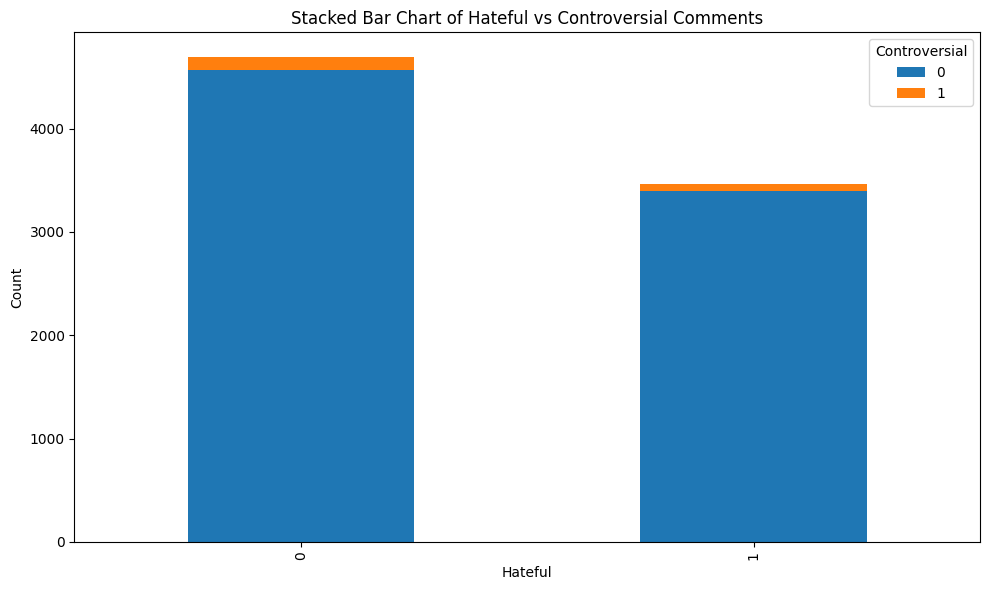

In [13]:
# Plotting relationship and distribution between controversiality and hatefulness
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar chart
counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Stacked Bar Chart of Hateful vs Controversial Comments')
ax.set_xlabel('Hateful')
ax.set_ylabel('Count')
ax.legend(title='Controversial')


plt.tight_layout()
plt.show()

### Can hatefullness be predicted using different comment features? Looking at the comment's position in the conv, the length of the conversation, the score, the subreddit and the author 9also for controversiality)

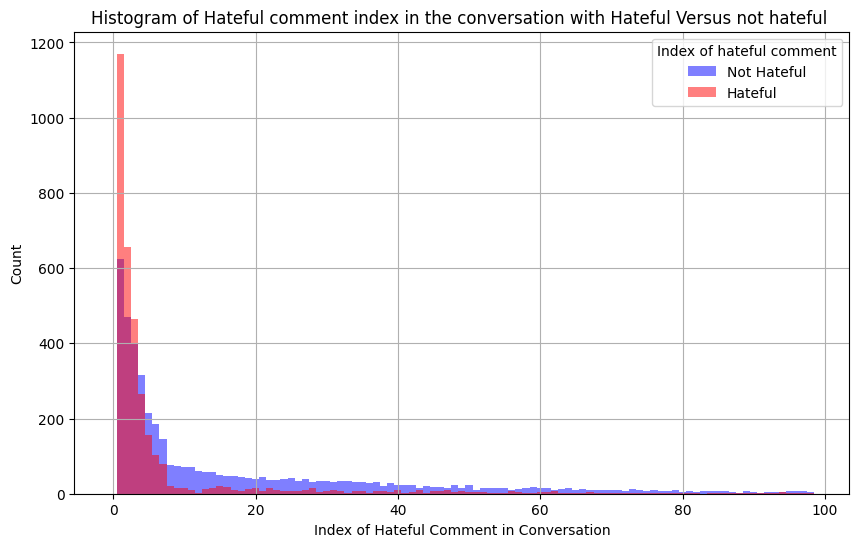

In [66]:

# Define bins for comment position inside the conversation
bins = np.arange(0, 100) - 0.5

# Create the histogram with stacked bars
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram
training_df[training_df['true_binary_label'] == 0]['index_in_conv'].hist(bins=bins, alpha=0.5, label='Not Hateful', color='blue', ax=ax)
training_df[training_df['true_binary_label'] == 1]['index_in_conv'].hist(bins=bins, alpha=0.5, label='Hateful', color='red', ax=ax)

ax.set_title('Histogram of Hateful comment index in the conversation with Hateful Versus not hateful ')
ax.set_xlabel('Index of Hateful Comment in Conversation')
ax.set_ylabel('Count')
ax.legend(title='Index of hateful comment')

# ça ne veut rien dire ce graf

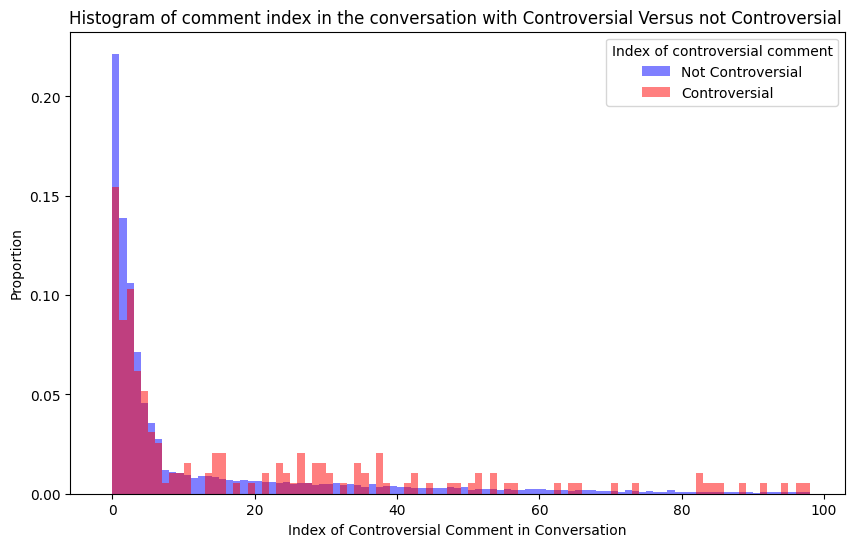

In [76]:
# Define bins for comment position inside the conversation
bins = np.arange(0, 100) - 0.5

# Create the histogram with stacked bars
fig, ax = plt.subplots(figsize=(10, 6))

# Compute the proportion of comments in each bin for each class
n_controversial = len(training_df[training_df['controversiality'] == 1])
n_not_controversial = len(training_df[training_df['controversiality'] == 0])

hist_controversial, _ = np.histogram(training_df[training_df['controversiality'] == 1]['index_in_conv'], bins=bins)
hist_not_controversial, _ = np.histogram(training_df[training_df['controversiality'] == 0]['index_in_conv'], bins=bins)

prop_controversial = hist_controversial / n_controversial
prop_not_controversial = hist_not_controversial / n_not_controversial

# Plot the histogram
ax.bar(bins[:-1], prop_not_controversial, width=1, alpha=0.5, label='Not Controversial', color='blue')
ax.bar(bins[:-1], prop_controversial, width=1, alpha=0.5, label='Controversial', color='red')

ax.set_title('Histogram of comment index in the conversation with Controversial Versus not Controversial ')
ax.set_xlabel('Index of Controversial Comment in Conversation')
ax.set_ylabel('Proportion')
ax.legend(title='Index of controversial comment')


In [15]:
training_df.head()

true_binary_label  index_in_conv  length_conv           author  \
0                  1              2           13           aqouta   
1                  1              1           15       oonniioonn   
2                  1              1           18     FACEBOOKFROG   
3                  0              1           73     normanbailer   
4                  0              4           73  Original-Newbie   

                                                body  controversiality  \
0  &gt;The Jewish nigger Lassalle who, I’m glad t...                 0   
1  You're fine with an explicit drawing of tranny...                 0   
2  So faggot copies r/bikinibottomtwitter, posts ...                 0   
3  "We got to get these faggots outa here"\n-Mike...                 0   
4  A bundle of sticks is known as a "faggot",\nal...                 0   

   subreddit label  score  parent_id  ... edited  post_created_utc  post_id  \
0      Drama   DEG      8    dmer3vt  ...      0        1504231976   6xblvu   
1  southpark   DEG    331  t3_6xc5z6  ...      0        1504238656   6xc5z6   
2      4chan   DEG    378  t3_6xcslr  ...      0        1504247220   6xcslr   
3       pics   HOM  18772  t3_6xegob  ...      0        1504271965   6xegob   
4       pics   NDG    131    dmfuwdw  ...      0        1504271965   6xegob   

   post_score post_parent_id  post_num_comments  \
0          62                                31   
1        1507                                30   
2       17809                                69   
3       18508                              2125   
4       18508                              2125   

                                          post_title  \
0  Literal giant Jewish spider in /r/propagandapo...   
1              As football approaches, go F yourself   
2                          /b/'s Spongebob Shit Post   
3  Vice president Mike Pence helping clear debris...   
4  Vice president Mike Pence helping clear debris...   

                                            post_url post_body post_selftext  
0  https://www.reddit.com/r/PropagandaPosters/com...        NA                
1                 https://i.redd.it/jvxiwwi047jz.jpg        NA                
2                     http://i.imgur.com/iWYeE2Z.jpg        NA     [deleted]  
3                 https://i.redd.it/l5cgem66v8jz.jpg        NA                
4                 https://i.redd.it/l5cgem66v8jz.jpg        NA                

[5 rows x 22 columns]

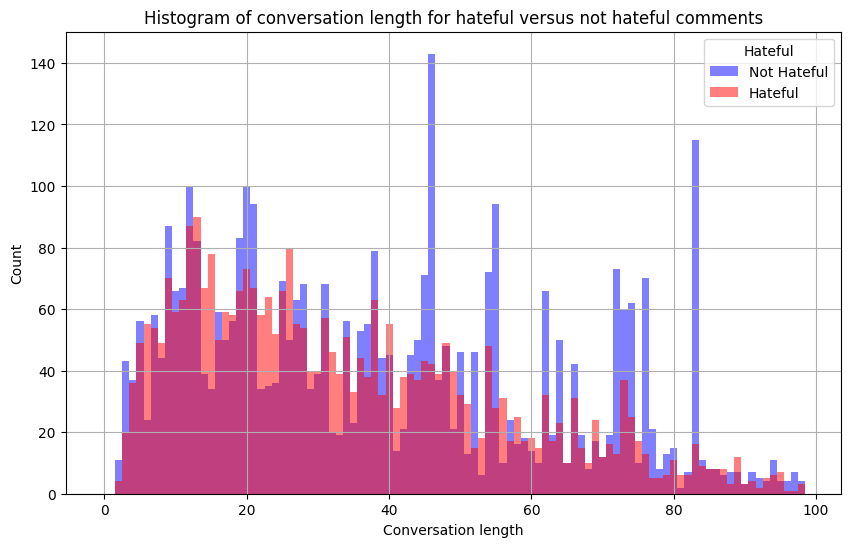

In [16]:
# Define bins for comment position inside the conversation
bins = np.arange(0, 100) - 0.5

# Create the histogram with stacked bars
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram
training_df[training_df['true_binary_label'] == 0]['length_conv'].hist(bins=bins, alpha=0.5, label='Not Hateful', color='blue', ax=ax)
training_df[training_df['true_binary_label'] == 1]['length_conv'].hist(bins=bins, alpha=0.5, label='Hateful', color='red', ax=ax)

ax.set_title('Histogram of conversation length for hateful versus not hateful comments')
ax.set_xlabel('Conversation length')
ax.set_ylabel('Count')
ax.legend(title='Hateful')

# ça ne veut rien dire ce graf

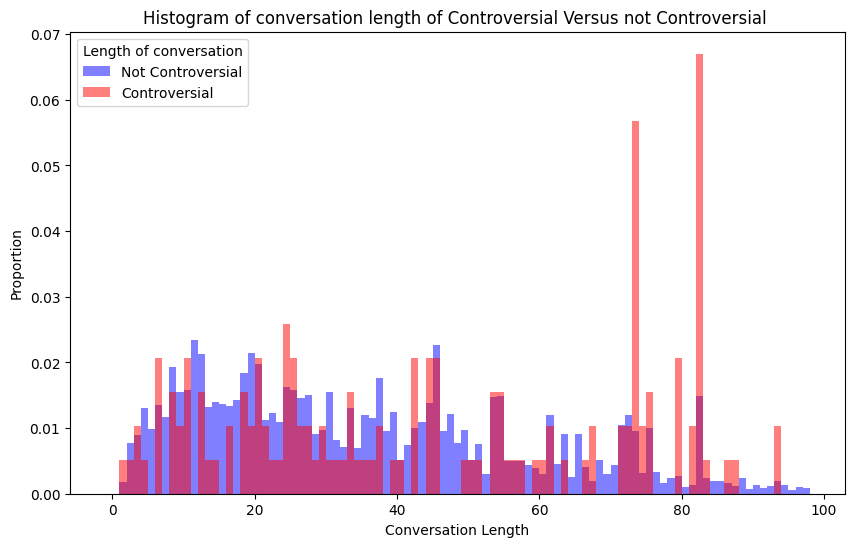

In [77]:
# Define bins for comment position inside the conversation
bins = np.arange(0, 100) - 0.5

# Create the histogram with stacked bars
fig, ax = plt.subplots(figsize=(10, 6))

# Compute the proportion of comments in each bin for each class
n_controversial = len(training_df[training_df['controversiality'] == 1])
n_not_controversial = len(training_df[training_df['controversiality'] == 0])

hist_controversial, _ = np.histogram(training_df[training_df['controversiality'] == 1]['length_conv'], bins=bins)
hist_not_controversial, _ = np.histogram(training_df[training_df['controversiality'] == 0]['length_conv'], bins=bins)

prop_controversial = hist_controversial / n_controversial
prop_not_controversial = hist_not_controversial / n_not_controversial

# Plot the histogram
ax.bar(bins[:-1], prop_not_controversial, width=1, alpha=0.5, label='Not Controversial', color='blue')
ax.bar(bins[:-1], prop_controversial, width=1, alpha=0.5, label='Controversial', color='red')

ax.set_title('Histogram of conversation length of Controversial Versus not Controversial ')
ax.set_xlabel('Conversation Length')
ax.set_ylabel('Proportion')
ax.legend(title='Length of conversation')

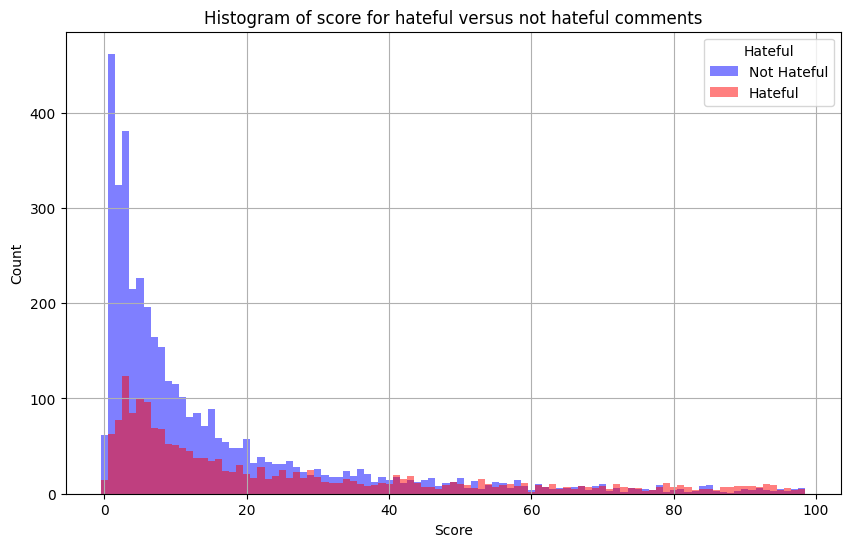

In [17]:
# Define bins for comment position inside the conversation
bins = np.arange(0, 100) - 0.5

# Create the histogram with stacked bars
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram
training_df[training_df['true_binary_label'] == 0]['score'].hist(bins=bins, alpha=0.5, label='Not Hateful', color='blue', ax=ax)
training_df[training_df['true_binary_label'] == 1]['score'].hist(bins=bins, alpha=0.5, label='Hateful', color='red', ax=ax)

ax.set_title('Histogram of score for hateful versus not hateful comments')
ax.set_xlabel('Score')
ax.set_ylabel('Count')
ax.legend(title='Hateful')

# ça ne veut rien dire ce graf

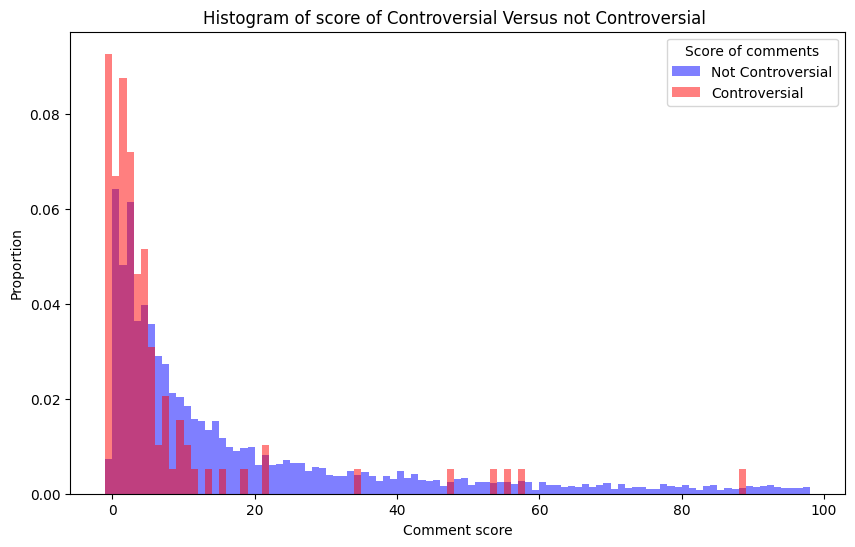

In [78]:
# Define bins for comment position inside the conversation
bins = np.arange(0, 100) - 0.5

# Create the histogram with stacked bars
fig, ax = plt.subplots(figsize=(10, 6))

# Compute the proportion of comments in each bin for each class
n_controversial = len(training_df[training_df['controversiality'] == 1])
n_not_controversial = len(training_df[training_df['controversiality'] == 0])

hist_controversial, _ = np.histogram(training_df[training_df['controversiality'] == 1]['score'], bins=bins)
hist_not_controversial, _ = np.histogram(training_df[training_df['controversiality'] == 0]['score'], bins=bins)

prop_controversial = hist_controversial / n_controversial 
prop_not_controversial = hist_not_controversial / n_not_controversial

# Plot the histogram
ax.bar(bins[:-1], prop_not_controversial, width=1, alpha=0.5, label='Not Controversial', color='blue')
ax.bar(bins[:-1], prop_controversial, width=1, alpha=0.5, label='Controversial', color='red')

ax.set_title('Histogram of score of Controversial Versus not Controversial ')
ax.set_xlabel('Comment score')
ax.set_ylabel('Proportion')
ax.legend(title='Score of comments')

In [18]:
grouped_df = training_df.groupby('subreddit')['true_binary_label'].sum().reset_index()
sorted_df = grouped_df.sort_values(by='true_binary_label', ascending=False)

print(f'there are {len(sorted_df['subreddit'])} different subreddits in the dataset')

sorted_df.head()


there are 677 different subreddits in the dataset


subreddit  true_binary_label
8                   4chan                283
148  ImGoingToHellForThis                228
436                 funny                185
550                  pics                180
68          CringeAnarchy                174

3467


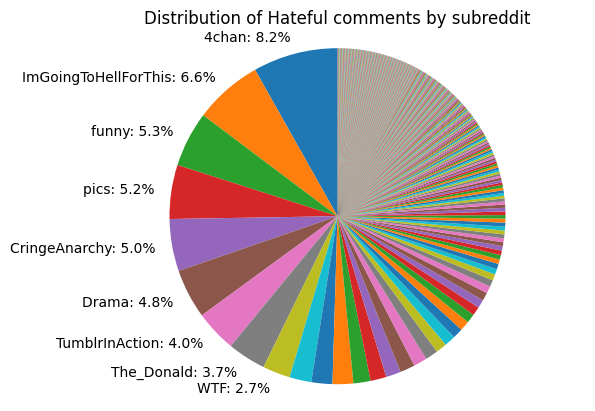

In [19]:
total_hate_labels = sorted_df['true_binary_label'].sum()
print(total_hate_labels)

fig, ax = plt.subplots()
# Create custom labels
labels = [
    f"{row['subreddit']}: {row['true_binary_label']*100/total_hate_labels:.1f}%" if row['true_binary_label'] >= 80 else ''
    for index, row in sorted_df.iterrows()
]
ax.pie(sorted_df['true_binary_label'], labels=labels, startangle=90)
ax.set_title('Distribution of Hateful comments by subreddit')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [68]:
grouped_df = training_df.groupby('author')['true_binary_label'].sum().reset_index()
sorted_df = grouped_df.sort_values(by='true_binary_label', ascending=False)

print(f'there are {len(sorted_df['author'])} different authors in the dataset')

sorted_df.head()

there are 6743 different authors in the dataset


author  true_binary_label
3930       [deleted]                 22
6576    watermark002                  6
1408  Grundleberries                  5
5701     oppaishorty                  5
5887      queerjihad                  5

3467


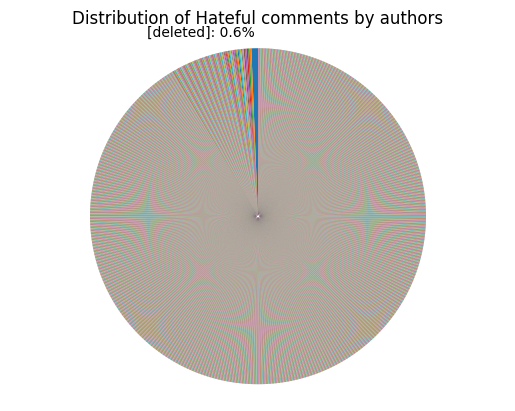

In [69]:
total_hate_labels = sorted_df['true_binary_label'].sum()
print(total_hate_labels)

fig, ax = plt.subplots()
# Create custom labels
labels = [
    f"{row['author']}: {row['true_binary_label']*100/total_hate_labels:.1f}%" if row['true_binary_label'] >= 10 else ''
    for index, row in sorted_df.iterrows()
]
ax.pie(sorted_df['true_binary_label'], labels=labels, startangle=90)
ax.set_title('Distribution of Hateful comments by authors')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [22]:
grouped_df = training_df.groupby('subreddit')['controversiality'].sum().reset_index()
sorted_df = grouped_df.sort_values(by='controversiality', ascending=False)

print(f'there are {len(sorted_df['subreddit'])} different subreddit in the dataset')

sorted_df.head()

there are 677 different subreddit in the dataset


subreddit  controversiality
86                  Drama                23
148  ImGoingToHellForThis                20
302        TumblrInAction                20
387            conspiracy                13
313        WatchRedditDie                 9

194


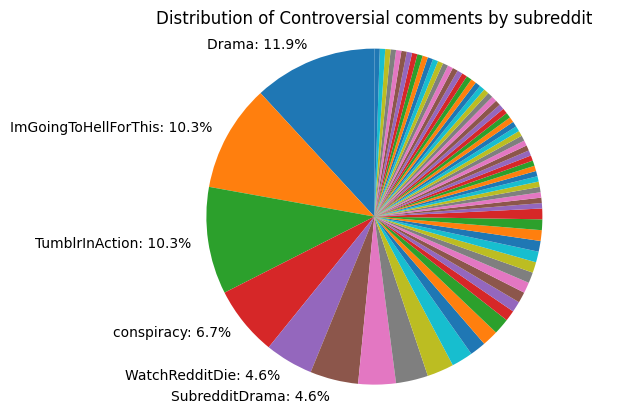

In [23]:
total_controv_labels = sorted_df['controversiality'].sum()

print(total_controv_labels)

fig, ax = plt.subplots()
# Create custom labels
labels = [
    f"{row['subreddit']}: {row['controversiality']*100/total_controv_labels:.1f}%" if row['controversiality'] >= 8 else ''
    for index, row in sorted_df.iterrows()
]
ax.pie(sorted_df['controversiality'], labels=labels, startangle=90)
ax.set_title('Distribution of Controversial comments by subreddit')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [24]:
grouped_df = training_df.groupby('author')['controversiality'].sum().reset_index()
sorted_df = grouped_df.sort_values(by='controversiality', ascending=False)

print(f'there are {len(sorted_df['author'])} different authors in the dataset')

sorted_df.head()

there are 6743 different authors in the dataset


author  controversiality
6576        watermark002                 8
3930           [deleted]                 5
5245  kittyhistoryistrue                 4
208           AmStupider                 3
1278          FullyWooly                 3

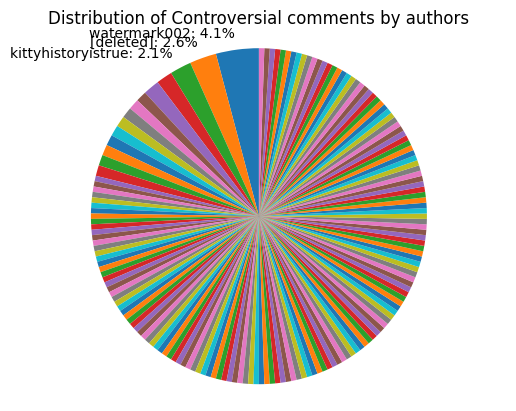

In [25]:

fig, ax = plt.subplots()
# Create custom labels
labels = [
    f"{row['author']}: {row['controversiality']*100/total_controv_labels:.1f}%" if row['controversiality'] >= 4 else ''
    for index, row in sorted_df.iterrows()
]
ax.pie(sorted_df['controversiality'], labels=labels, startangle=90)
ax.set_title('Distribution of Controversial comments by authors')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Let's look at some text examples :) Can a human label hatefullness and controversiality in this dataset?

In [71]:
test_texts = []
i = 0
# Some examples of controv comments that are hateful
hate_and_controv = training_df[(training_df["controversiality"] == 1) & (training_df["true_binary_label"] == 1)].sample(frac=1)
for comment in hate_and_controv["body"]:
    print(comment)
    print("...................................\n")
    if i < 10:
        i = i + 1
        test_texts.append(comment)

Sounds like youve been affected by the nigger gene.
...................................

Right wing zionists are worse than leftist zionists. You do realize Israel is not a friend of the US? It has betrayed us on multiple occasions and yet US politicians keep shilling for Jewish interests. The left loves the Jews since their organizations push leftist interests too.
...................................

"Huge". What a faggot you are. It was a non-issue that C9 only "cleaned up" because Intel, their biggest sponsor, is running a big anti-bullying campaign. Nobody else gave two fucks.
...................................

That chick isn't obese LMBO. It's obviously a flattering picture if she put it on Tantan but she sure as hell doesn't look that fucking fat.
...................................

/r/fullcommunism got quarantined a long time ago. Somehow an endless fit was not thrown over it though in billionaire funded right wing propaganda journals. The left is censored all the time, in f

In [72]:
# Some examples of controv comments that are NOT hateful
print("Some examples of controv comments that are NOT hateful\n")
print("...................................\n")
nothate_and_controv = training_df[(training_df["controversiality"] == 1) & (training_df["true_binary_label"] == 0)].sample(frac=1)
for comment in nothate_and_controv["body"]:
    print(comment)
    print("...................................\n")
    if i < 20:
        i = i + 1
        test_texts.append(comment)

Some examples of controv comments that are NOT hateful

...................................

Maybe just let me know calmly and nicely rather than being a spazatron Spergboy about it
...................................

That nigger guy? 

Edit: It's a South Park reference you shitty dopes, some fucking dopes in this sub yeah 
...................................

&gt;Imagine watching the legitimately elected president be hamstrung left and right by government officials both elected and unelecte

Trump is not hamstrung.  Inconvenienced and hampered?  Sure, just like every other president.  The only thing Trump has had to deal with that others haven't is an incredibly hostile media (arguably something Trump himself intentionally caused) and Mueller (arguably something that's done far more harm than good to the DNC's agenda.)

Even so, he's been accomplishing a shitload.  The issues the Media can't shut up about are the red cloth he waves in front of them while he gets shit done behind the 

In [73]:
# Some examples of NON controv comments that are hateful
print("Some examples of NON controv comments that are  hateful\n")
print("...................................\n")
hate_and_notcontrov = training_df[(training_df["controversiality"] == 0) & (training_df["true_binary_label"] == 1)].sample(frac=1)
for comment in hate_and_notcontrov["body"]:
    print(comment)
    print("...................................\n")
    if i < 30:
        i = i + 1
        test_texts.append(comment)

Some examples of NON controv comments that are  hateful

...................................

I haven't found any. I take some and leave some, practicing what I call "mental discernment" where ideally the untruth is perceived for what it is. It is a difficult ability to cultivate, but one well worth acquiring, since nobody seems to be telling the whole story.

There would be my own videos, but they are not in English and "only" pertain to life and mind. Which are, if you really consider the question honestly, the only things we actually have.

In other words, my view is we should make our lives great, make them matter, and for that we need access to certain states, and worrying about what (((they))) might be doing is utterly counterproductive. It is still interesting to consider these things, but avoiding fascination or worry, instead focusing on bettering one's life.
...................................

How long have I been asleep....why is everyone trans or super duper pro-trans now?

In this section, I will try to understand comments, conversations and submissions. What are the differences between these 3 notions and what pieces of information are available for each category. 

In [74]:
# Some examples of NON controv comments that are NOT hateful
print("Some examples of NON controv comments that are NOT hateful\n")
print("...................................\n")
nothate_and_notcontrov = training_df[(training_df["controversiality"] == 0) & (training_df["true_binary_label"] == 0)].sample(frac=1)
for comment in nothate_and_notcontrov["body"]:
    print(comment)
    print("...................................\n")
    if i < 40:
        i = i + 1
        test_texts.append(comment)

Some examples of NON controv comments that are NOT hateful

...................................

Kerala is second in line for next Paxtan. WB is first.
...................................

I live in Iowa.  At the hospital where I work someone made a comment that Obama was a "dumb nigger wearing a suit."  I turned around and said "Well, at least Palin isn't the president."  I got shot looks from everyone around me like I had just committed blasphemy.
...................................

When ever I explain what being pan is somebody always nonchalantly says  "so you like trannies," that just pisses me off they say it like that.
...................................

&gt;My pronouns are ♩/♪.

If anyone asks, just tell them it's pronounced faggot/faggotir and watch them squirm.
...................................

&gt; Far superior to metal in terms of melody and variety. 

Clearly you haven’t listened to much metal
...................................

☑️ Y'ALL

☑️ Invokes CURRENT YEAR

☑️ 

### What about using emotions? Can emotions help us classify HS and controversiallity here?

In [30]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base")


In [31]:
print(len(test_texts))
test_texts

40


["Nope. I'm left as hell, and the tranny stuff is ridiculous. ",
 'The tranny behind the gloryhole accidentally knocked it down. ',
 'ugh i hate photos like these. i feel like i cant scratch my balls while im outside of the house without some little faggot with a smart phone taking a picture of me. ',
 "I'll buy a vape set if you post a video of you holding a tranny porn mag and winking into the camera.",
 'Is that the tranny from the orange is the new black?',
 'I dont get Emma Watson. She looks like a tranny Richard Dawkins. \n\n[link](https://skitch-img.s3.amazonaws.com/20090712-jjpdfei8iithxb9m6uk24pc6m5.png)\n\n\nedit: haha sore spot, huh?',
 '&gt;I\'d take my pet to the vet as soon as  I\'d see he was doing something like this, not go "oh, what a cute littel move you got".\n\nThe post I was looking for. Someone being a pretentious faggot about animal ownership. I\'m sure the owner will be very knowledgeable about this now that he has hundreds of people like you telling him what i

In [32]:
# Tokenize the texts
inputs = tokenizer(test_texts, return_tensors="pt", padding=True, truncation=True)

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted emotions
predictions = torch.argmax(outputs.logits, dim=-1)

# Define the emotion labels
emotion_labels = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]

# Map the predictions to labels
predicted_emotions = [emotion_labels[pred] for pred in predictions]

j = 0
# Print the results
for text, emotion in zip(test_texts, predicted_emotions):
    if j == 0:
        print("............... hate and controv .................... \n")
    if j == 10:
        print("............... controv not hateful ................. \n")
    if j == 20:
        print("............... hate and not controv ................ \n")
    if j == 30:
        print("............... not hate and not controv ............. \n")
    print(f"Text: {text}\nPredicted Emotion: {emotion}\n")
    j = j + 1

............... hate and controv .................... 

Text: Nope. I'm left as hell, and the tranny stuff is ridiculous. 
Predicted Emotion: disgust

Text: The tranny behind the gloryhole accidentally knocked it down. 
Predicted Emotion: neutral

Text: ugh i hate photos like these. i feel like i cant scratch my balls while im outside of the house without some little faggot with a smart phone taking a picture of me. 
Predicted Emotion: anger

Text: I'll buy a vape set if you post a video of you holding a tranny porn mag and winking into the camera.
Predicted Emotion: neutral

Text: Is that the tranny from the orange is the new black?
Predicted Emotion: neutral

Text: I dont get Emma Watson. She looks like a tranny Richard Dawkins. 

[link](https://skitch-img.s3.amazonaws.com/20090712-jjpdfei8iithxb9m6uk24pc6m5.png)


edit: haha sore spot, huh?
Predicted Emotion: neutral

Text: &gt;I'd take my pet to the vet as soon as  I'd see he was doing something like this, not go "oh, what a cute l

In [33]:
# Function to get emotion from text
def get_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    prediction = torch.argmax(logits, dim=-1).item()  # Convert tensor to a scalar value
    return emotion_labels[prediction]

training_df['emotion'] = training_df['body'].apply(get_emotion)

# Display the DataFrame with the new 'emotion' column
print(training_df[['body', 'emotion']])


                                                   body   emotion
0     &gt;The Jewish nigger Lassalle who, I’m glad t...       joy
1     You're fine with an explicit drawing of tranny...   disgust
2     So faggot copies r/bikinibottomtwitter, posts ...   neutral
3     "We got to get these faggots outa here"\n-Mike...     anger
4     A bundle of sticks is known as a "faggot",\nal...   disgust
...                                                 ...       ...
8158  just use the men's restroom. If someone questi...   disgust
8159  Wait.... wait wait WAIT!\n\n#WAIT!\n\nYou're t...  surprise
8160  It's obviously fake. Unless you're a faggot, n...   disgust
8161  I play something I like to call Tumblr roulett...      fear
8162  little fat boys like you should be careful abo...   neutral

[8163 rows x 2 columns]


### Let's plot emotion distributions for hateful/non-hateful comments and controversial/non-controversial comments

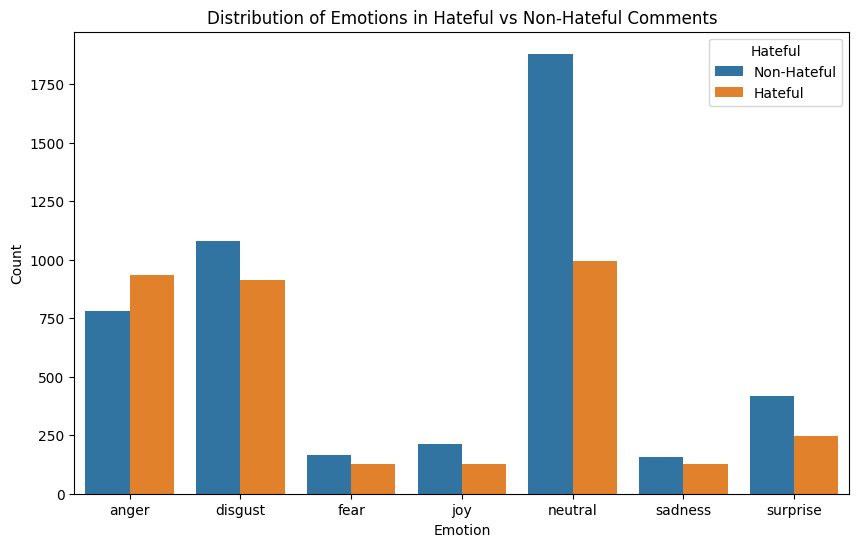

In [34]:
# Count occurrences of each emotion for hateful and non-hateful comments
emotion_counts = training_df.groupby(['true_binary_label', 'emotion']).size().reset_index(name='count')

# Pivot the data for easier plotting
emotion_pivot = emotion_counts.pivot(index='emotion', columns='true_binary_label', values='count').fillna(0)
emotion_pivot.columns = ['Non-Hateful', 'Hateful']
emotion_pivot = emotion_pivot.reset_index()

# Melt the DataFrame for seaborn
emotion_melt = pd.melt(emotion_pivot, id_vars='emotion', value_vars=['Non-Hateful', 'Hateful'], var_name='Hateful', value_name='Count')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='emotion', y='Count', hue='Hateful', data=emotion_melt)
plt.title('Distribution of Emotions in Hateful vs Non-Hateful Comments')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

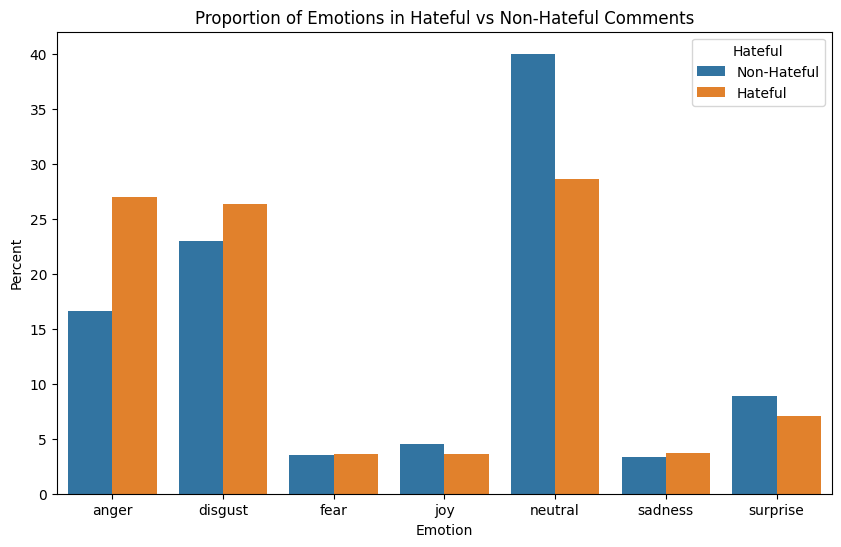

In [43]:
# Count occurrences of each emotion for hateful and non-hateful comments
emotion_counts = training_df.groupby(['true_binary_label', 'emotion']).size().reset_index(name='count')

# Calculate the total counts for hateful and non-hateful comments
total_counts = training_df['true_binary_label'].value_counts()

# Calculate the proportions
emotion_counts['proportion'] = emotion_counts.apply(
    lambda row: row['count'] * 100 / total_counts[row['true_binary_label']], axis=1
)

# Pivot the data for easier plotting
emotion_pivot = emotion_counts.pivot(index='emotion', columns='true_binary_label', values='proportion').fillna(0)
emotion_pivot.columns = ['Non-Hateful', 'Hateful']
emotion_pivot = emotion_pivot.reset_index()

# Melt the DataFrame for seaborn
emotion_melt = pd.melt(emotion_pivot, id_vars='emotion', value_vars=['Non-Hateful', 'Hateful'], var_name='Hateful', value_name='Proportion')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='emotion', y='Proportion', hue='Hateful', data=emotion_melt)
plt.title('Proportion of Emotions in Hateful vs Non-Hateful Comments')
plt.xlabel('Emotion')
plt.ylabel('Percent')
plt.show()

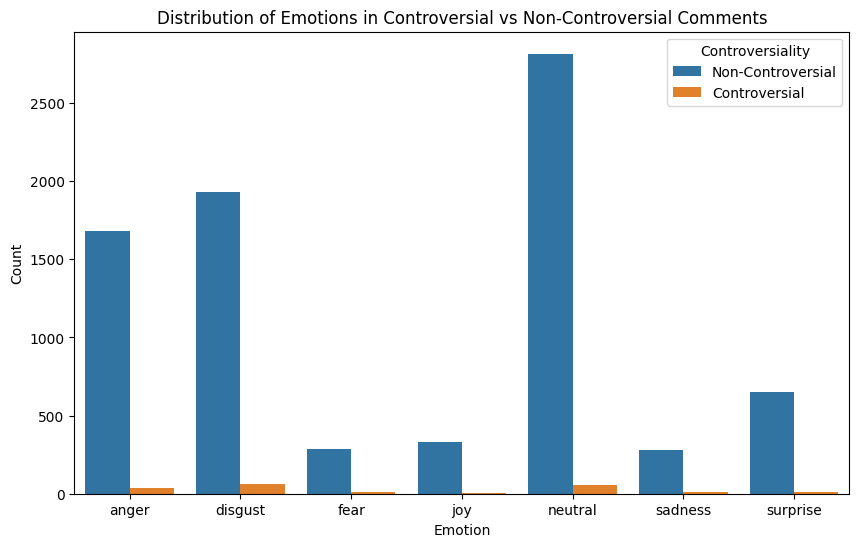

In [36]:
# Count occurrences of each emotion for controversial and non-controversial comments
emotion_counts = training_df.groupby(['controversiality', 'emotion']).size().reset_index(name='count')

# Pivot the data for easier plotting
emotion_pivot = emotion_counts.pivot(index='emotion', columns='controversiality', values='count').fillna(0)
emotion_pivot.columns = ['Non-Controversial', 'Controversial']
emotion_pivot = emotion_pivot.reset_index()

# Melt the DataFrame for seaborn
emotion_melt = pd.melt(emotion_pivot, id_vars='emotion', value_vars=['Non-Controversial', 'Controversial'], var_name='Controversiality', value_name='Count')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='emotion', y='Count', hue='Controversiality', data=emotion_melt)
plt.title('Distribution of Emotions in Controversial vs Non-Controversial Comments')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

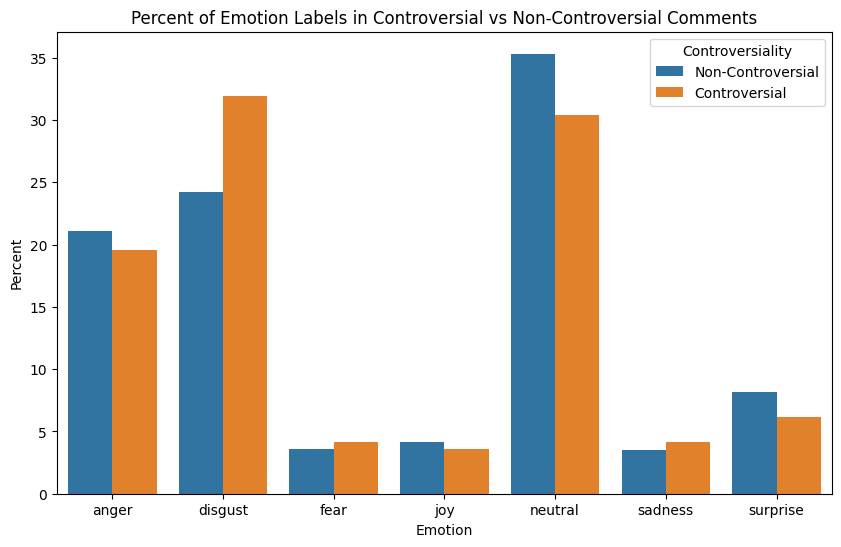

In [42]:
# Count occurrences of each emotion for controversial and non-controversial comments
emotion_counts = training_df.groupby(['controversiality', 'emotion']).size().reset_index(name='count')

# Calculate the total counts for controversial and non-controversial comments
total_counts = training_df['controversiality'].value_counts()

# Calculate the proportions
emotion_counts['proportion'] = emotion_counts.apply(
    lambda row: row['count'] * 100 / total_counts[row['controversiality']], axis=1
)

# Pivot the data for easier plotting
emotion_pivot = emotion_counts.pivot(index='emotion', columns='controversiality', values='proportion').fillna(0)
emotion_pivot.columns = ['Non-Controversial', 'Controversial']
emotion_pivot = emotion_pivot.reset_index()

# Melt the DataFrame for seaborn
emotion_melt = pd.melt(emotion_pivot, id_vars='emotion', value_vars=['Non-Controversial', 'Controversial'], var_name='Controversiality', value_name='Percent')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='emotion', y='Percent', hue='Controversiality', data=emotion_melt)
plt.title('Percent of Emotion Labels in Controversial vs Non-Controversial Comments')
plt.xlabel('Emotion')
plt.ylabel('Percent')
plt.show()

### Toxicity classification 

#### DistilBERT toxic comment model 

In [51]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Create the pipeline with truncation and padding
pipeline = TextClassificationPipeline(
    model=model, 
    tokenizer=tokenizer,
    padding=True, 
    truncation=True, 
    max_length=512
)
print(pipeline('This is a test text.'))

[{'label': 'non-toxic', 'score': 0.9990898370742798}]


In [52]:
# Function to get emotion from text
def get_toxicity(text):
    results = pipeline(text) 
    return results[0]['label'], results[0]['score']

training_df['distil-toxic-label'], training_df['distil-toxic-score'] = zip(*training_df['body'].apply(get_toxicity))

# Display the DataFrame with the new 'emotion' column
#print(training_df[['body', 'emotion']])
#print(pipeline('Fuck you motherfucker I dont want to see your shitty face'))

In [64]:
def evaluate_metrics(pred_col, gt_col, toxic_label, nontoxic_label, df):
    total = len(df[pred_col])
    tp = len(df[(df[pred_col] == toxic_label) & (df[gt_col] == 1)])
    tn = len(df[(df[pred_col] == nontoxic_label) & (df[gt_col] == 0)])
    fn = len(df[(df[pred_col] == nontoxic_label) & (df[gt_col] == 1)])
    fp = len(df[(df[pred_col] == toxic_label) & (df[gt_col] == 0)])
    assert (tp + tn + fn + fp) == total
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1
    

accuracy, precision, recall, f1 = evaluate_metrics('distil-toxic-label', 'true_binary_label', 'toxic', 'non-toxic', training_df)

print("Using martin-ha/toxic-comment-model's model on hateful discussions dataset, we get the following results: ")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Using martin-ha/toxic-comment-model's model on hateful discussions dataset, we get the following results: 
Accuracy: 0.6028
Precision: 0.5506
Recall: 0.3533
F1 Score: 0.4304


#### Now let's try fb roberta model 

In [85]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
import pandas as pd

# Load the model and tokenizer
model_path = "facebook/roberta-hate-speech-dynabench-r4-target"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Create the pipeline with truncation and padding
pipeline = TextClassificationPipeline(
    model=model, 
    tokenizer=tokenizer,
    padding=True, 
    truncation=True, 
    max_length=512
)

print(pipeline('This is just a small example'))
print(pipeline('Fuck you motherfucker I dont want to see your shitty face'))
print(pipeline('I hate black people they smell like shit and are stupid as fuck, brrrrr'))
print(pipeline('I hate frog eaters because they smell like shit and are stupid as fuck, brrrrr'))



[{'label': 'nothate', 'score': 0.9997599720954895}]
[{'label': 'nothate', 'score': 0.9997943043708801}]
[{'label': 'hate', 'score': 0.9997391104698181}]
[{'label': 'nothate', 'score': 0.9998010993003845}]


In [62]:
training_df['fbroberta-hate-label'], training_df['fbroberta-hate-score'] = zip(*training_df['body'].apply(get_toxicity))


In [65]:
accuracy_fb, precision_fb, recall_fb, f1_fb = evaluate_metrics('fbroberta-hate-label', 'true_binary_label', 'hate', 'nothate', training_df)

print("Using facebook/roberta-hate-speech-dynabench-r4-target's model on hateful discussions dataset, we get the following results: ")
print(f"Accuracy: {accuracy_fb:.4f}")
print(f"Precision: {precision_fb:.4f}")
print(f"Recall: {recall_fb:.4f}")
print(f"F1 Score: {f1_fb:.4f}")


Using facebook/roberta-hate-speech-dynabench-r4-target's model on hateful discussions dataset, we get the following results: 
Accuracy: 0.7890
Precision: 0.7195
Recall: 0.8249
F1 Score: 0.7686


Look at wrongly classified data points to try to understand why the model makes mistakes

In [116]:
unsure_preds = training_df[training_df['fbroberta-hate-score'] < 0.55].sample(frac=1)
unsure_preds.head()

true_binary_label  index_in_conv  length_conv              author  \
3911                  1            160          207          diggity_md   
131                   0              2           14    bendslikeawillow   
2811                  0            174          195         hannahranga   
5721                  1              7           59           EpicGuard   
3936                  0            190          207  GaysianSupremacist   

                                                   body  controversiality  \
3911  &gt; wammen wants a fwb relationship\n\nOMG so...                 0   
131   &gt;Be careful, gendercritical is absolutely g...                 0   
2811  &gt;  If you don't have dysphoria, that means ...                 0   
5721  Lol. So many people on /r/aww just want to bel...                 0   
3936          Conversion therapy for straight guys now!                 0   

                 subreddit                  label  score  parent_id  ...  \
3911                 Drama  IdentityDirectedAbuse     74    es5x557  ...   
131   traaaaaaannnnnnnnnns                    NDG      8    dni0jax  ...   
2811        TumblrInAction                Neutral      0    epwnjl6  ...   
5721                   aww                    DEG     -6    ca3syfu  ...   
3936                 Drama                Neutral      1  t3_c634lj  ...   

                                             post_title  \
3911                       Holy shit Reddit is retarded   
131   I got cat-called for the first time in girl-mo...   
2811                                   This man gets it   
5721  She jumps in the shower, regrets everything, j...   
3936                       Holy shit Reddit is retarded   

                                               post_url  post_body  \
3911  https://www.reddit.com/r/AmItheAsshole/comment...         NA   
131                  https://i.redd.it/2vc8lgkuy1oz.jpg         NA   
2811                https://i.redd.it/4mt1a61q7y131.jpg         NA   
5721                     http://i.imgur.com/lacBoGi.jpg         NA   
3936  https://www.reddit.com/r/AmItheAsshole/comment...         NA   

      post_selftext   emotion  distil-toxic-label distil-toxic-score  \
3911                 surprise           non-toxic           0.984225   
131                      fear           non-toxic           0.741988   
2811                  neutral           non-toxic           0.950335   
5721                    anger               toxic           0.825499   
3936                  neutral           non-toxic           0.998348   

      fbroberta-hate-label fbroberta-hate-score count  
3911                  hate             0.520126     1  
131                   hate             0.531940     1  
2811                  hate             0.529645     1  
5721               nothate             0.513110     1  
3936                  hate             0.523532     1  

[5 rows x 28 columns]

In [118]:
# Some examples of unsure predictions
print("Some examples of UNSURE predictions by Fb Hateful Comments model (where proba true pred < 0.55\n")
print("There are ", len(unsure_preds['body']), " such cases in the training dataset" )
print("...................................\n")
for comment in unsure_preds["body"]:
    print(comment)
    print("...................................\n")


Some examples of UNSURE predictions by Fb Hateful Comments model (where proba true pred < 0.55

There are  81  such cases in the training dataset
...................................

&gt; wammen wants a fwb relationship

OMG so empowered and professional 😍😍😍

&gt; man wants fwb relationship 

y i k e s 😬😬😬 don't you know that's sexist?
...................................

&gt;Be careful, gendercritical is absolutely going to take this and use it saying "blatant fetishization of the female experience, fucking trannies." 

Sounds like code for "a trans woman looks better than me, boo hoo"
 
...................................

&gt;  If you don't have dysphoria, that means you're comfortable with your genitals, meaning you aren't trans.

So following that logic someone post SRS that now has a set of genitals they're happy with isn't transgender?
...................................

Lol. So many people on /r/aww just want to believe. 

Guess what...people lie for karma even though it's not

In [119]:
big_false_pos = training_df[(training_df['true_binary_label'] == 0) & (training_df['fbroberta-hate-label'] == 'hate') & (training_df['fbroberta-hate-score'] > 0.9)].sample(frac=1)
big_false_pos.head()

true_binary_label  index_in_conv  length_conv                author  \
1634                  0             93          129  RedditJusticeWarrior   
5935                  0              1           36   shitposteranonymous   
5526                  0             22           34           greenwrayth   
614                   0              9           28       rockpileindisma   
2222                  0              2           76             Aqquila89   

                                                   body  controversiality  \
1634       Citizens should be allowed to have ordnance.                 0   
5935  Congrats to our Dangerous Faggot on his quick ...                 0   
5526  Considering it’s because of how they used to *...                 0   
614                 Not even white people are safe here                 0   
2222  Milo said it's okay to use "faggot", and since...                 0   

                 subreddit    label  score  parent_id  ...  \
1634      ShitPoliticsSays  Neutral      5    ephqt8e  ...   
5935            The_Donald      NDG    171  t3_6fgiyc  ...   
5526               gay_irl      NDG     17    exsqkio  ...   
614   ImGoingToHellForThis  Neutral      9    em9gbi7  ...   
2222       EnoughTrumpSpam      NDG   1065    d4go4px  ...   

                                             post_title  \
1634  The only way to save America is to kill all Re...   
5935  Milo Yiannopoulos' book outsells Chelsea Clint...   
5526                                            Gay irl   
614                          What weapon do you choose?   
2222  /r/The_Donald takes a brave stand against wome...   

                                               post_url  post_body  \
1634  https://www.reddit.com/r/worldnews/comments/bu...         NA   
5935  http://redalertpolitics.com/2017/06/05/milo-yi...         NA   
5526                https://i.redd.it/h5y49kqw82i31.jpg         NA   
614                 https://i.redd.it/ekk5kwntwmv21.jpg         NA   
2222                    https://i.imgur.com/YF6jc5n.png         NA   

      post_selftext  emotion  distil-toxic-label distil-toxic-score  \
1634                 neutral           non-toxic           0.998279   
5935                   anger           non-toxic           0.956013   
5526                   anger           non-toxic           0.857673   
614                  neutral           non-toxic           0.680536   
2222                 neutral           non-toxic           0.809921   

      fbroberta-hate-label fbroberta-hate-score count  
1634                  hate             0.994202     1  
5935                  hate             0.998867     1  
5526                  hate             0.999636     1  
614                   hate             0.954605     1  
2222                  hate             0.997720     1  

[5 rows x 28 columns]

In [120]:
# Some examples of big false positives predictions
print("Some examples of BIG false positives by Fb Hateful Comments model (where proba true pred > 0.9 and the prediction is 'hate' but it is a mistake\n")
print("There are ", len(big_false_pos['body']), " such cases in the training dataset" )

print("...................................\n")
for comment in big_false_pos["body"]:
    print(comment)
    print("...................................\n")

Some examples of BIG false positives by Fb Hateful Comments model (where proba true pred > 0.9 and the prediction is 'hate' but it is a mistake

There are  839  such cases in the training dataset
...................................

Citizens should be allowed to have ordnance.
...................................

Congrats to our Dangerous Faggot on his quick rise back to the top. May he burn the MSM to the ground!
...................................

Considering it’s because of how they used to *bundle queer folk with a bunch of faggots (i.e. sticks) so they would burn alive* like I kind of understand why.
...................................

Not even white people are safe here
...................................

Milo said it's okay to use "faggot", and since he's the Emperor of Gay People, it means that everyone can say it now.
...................................

This mudshark is hilarious. She casually says “nigger”, and wants a goddamn unicorn, looking for not just a man who will 

In [121]:
big_false_neg = training_df[(training_df['true_binary_label'] == 1) & (training_df['fbroberta-hate-label'] == 'nothate') & (training_df['fbroberta-hate-score'] > 0.9)].sample(frac=1)
big_false_neg.head()

true_binary_label  index_in_conv  length_conv                author  \
4549                  1              5            7        KarosGraveyard   
2681                  1              1            4       Glock9mmInMyLLQ   
1155                  1             87          101     ExceedinglyPanFox   
2780                  1            130          195              vitrucid   
4393                  1              4           20  MiltonFriedmanisbae1   

                                                   body  controversiality  \
4549  I’m not suggesting people start doing it, but ...                 0   
2681  What's exactly is the deal with the fruity-ass...                 1   
1155  Do they have a central leader? I thought it wa...                 0   
2780  Because heaven forbid we ever acknowledge that...                 0   
4393  i don't power-jannie for jannies sake. I do it...                 0   

           subreddit                     label  score  parent_id  ...  \
4549  WatchRedditDie  AffiliationDirectedAbuse      1    et8mhzv  ...   
2681          Glocks                       DEG     -1  t3_bvtj40  ...   
1155  SubredditDrama  AffiliationDirectedAbuse      5    entevb1  ...   
2780  TumblrInAction     IdentityDirectedAbuse      3    epunyzo  ...   
4393           Drama  AffiliationDirectedAbuse     19    esi12qh  ...   

                                             post_title  \
4549  Bourgeoisie anti-racists are welcome to start ...   
2681                                           Long boi   
1155              r/Cantelmoism accused of being a cult   
2780                                   This man gets it   
4393  My tenure as Power-Jannie representing r/drama...   

                                               post_url  post_body  \
4549                https://i.redd.it/f02bcnhq6y831.png         NA   
2681                https://i.redd.it/d0ng131fav131.jpg         NA   
1155  https://www.reddit.com/r/TheoryOfReddit/commen...         NA   
2780                https://i.redd.it/4mt1a61q7y131.jpg         NA   
4393                https://i.redd.it/9adygywfdq731.png         NA   

      post_selftext   emotion  distil-toxic-label distil-toxic-score  \
4549                  neutral           non-toxic           0.998504   
2681                 surprise           non-toxic           0.995193   
1155                  neutral           non-toxic           0.955408   
2780                  disgust               toxic           0.911906   
4393                      joy           non-toxic           0.997139   

      fbroberta-hate-label fbroberta-hate-score count  
4549               nothate             0.994563     1  
2681               nothate             0.999541     1  
1155               nothate             0.999794     1  
2780               nothate             0.987899     1  
4393               nothate             0.943602     1  

[5 rows x 28 columns]

In [122]:
# Some examples of big false positives predictions
print("Some examples of BIG false negativew by Fb Hateful Comments model (where proba true pred > 0.9 and the prediction is 'nothate' but it is a mistake\n")
print("There are ", len(big_false_neg['body']), " such cases in the training dataset" )

print("...................................\n")
for comment in big_false_neg["body"]:
    print(comment)
    print("...................................\n")

Some examples of BIG false negativew by Fb Hateful Comments model (where proba true pred > 0.9 and the prediction is 'nothate' but it is a mistake

There are  391  such cases in the training dataset
...................................

I’m not suggesting people start doing it, but people will use drastic measures to defend themselves when they’re backed into a corner. 

These antifa dipshits dont seem to understand that
...................................

What's exactly is the deal with the fruity-assed "boi" spelling? I've seen it used all over this sub....WTF does boi actually mean? Does that term involve trannies from Thailand or something similar?
...................................

Do they have a central leader? I thought it was just a bunch of crazy people all contributing their small part to the crazy whole rather than one person leading a cult.
...................................

Because heaven forbid we ever acknowledge that there's something mentally deviant relating to LG

The submission dataset columns are:

-subreddit: the name of the subredit 
-id: submission id
-author: anonymized user id (random)
-timestamp: date + time of post
-text: text content of submission
-title: title of the submission
-score: approximation of the diff between up and down votes
-upvote_ratio: ratio upvotes/total_votes
-upvotes: approximation of the diff between up and down votes


## Controversial 

We will now zoom into the conversial labelling of reddit comments. 

In [ ]:
controv = comments_sample[comments_sample['controversial'] == 1]

In [ ]:
controv

subreddit       id  \
45              news  k86sn6x   
106        worldnews  k97le47   
146    anime_titties  k8g1sxc   
160  IsraelPalestine  kbb255f   
218           europe  k8mmowa   
256          NewIran  ka08mjj   
267             news  kaybtgg   
396           europe  k9pnlv3   
418         politics  k7nn9qu   
432        worldnews  kb358wx   
462           europe  kawfjc2   

                                                  text               author  \
45   >pro israel protests generally aren't making h...       jmpwfnzdbu3129   
106  or perhaps, and hear me out, the illegal occup...  Jnbhjobsz_Efbmfs789   
146  that's the point i am raising. just google it,...       fmbufe_ebwjodj   
160  plenty of deranged folks still wearing blue an...    KbnftKptfqiNfflfs   
218  stop being dishonest. zionists opposed the pee...     GbuifsIbdlKbdlfu   
256  i am pro-zionist. iranians literally invented ...          JsbojdVojuz   
267  b. the people that violated the ceasefire 15 m...            Sbwfo234y   
396  what natives? jews are native to israel. their...   IfbmuizDpnnfou6484   
418                                               this             JdzTipft   
432  > without any suggestion as to what to really ...            esfbedbjo   
462  throwing a live grenade on children and gettin...           jubnbsd248   

              timestamp submission_id  controversial  score  ups  downs  \
45  2023-11-07 08:06:24       17pm1n3              1     -4   -4      0   
106 2023-11-14 13:43:28       17ujruz              1     -3   -3      0   
146 2023-11-09 02:01:36       17qtbv0              1      4    4      0   
160 2023-11-29 20:05:20       186yfpn              1      2    2      0   
218 2023-11-10 10:14:24       17rzrfr              1    -12  -12      0   
256 2023-11-20 11:50:24       17z43ed              1      4    4      0   
267 2023-11-27 08:51:12       184puab              1     -4   -4      0   
396 2023-11-18 01:21:04       17xctyy              1      1    1      0   
418 2023-11-03 14:43:12       17mtpz9              1      1    1      0   
432 2023-11-28 06:45:20       185ihf5              1      2    2      0   
462 2023-11-26 23:08:48       184kmkf              1     -6   -6      0   

    parent_id  
45    k86qemb  
106   k962olu  
146   k8fzeda  
160   186yfpn  
218   k8mlyyn  
256   ka07zrm  
267   kaxqmga  
396   k9p1842  
418   k7nn438  
432   kb3338u  
462   kawesvj

In [ ]:
controv.count()

subreddit        11
id               11
text             11
author           11
timestamp        11
submission_id    11
controversial    11
score            11
ups              11
downs            11
parent_id        11
dtype: int64

The sample dataset contains 11 (out of 500) examples of controversial comments (2%). 

In [ ]:
downs = comments_sample[comments_sample['downs'] != 0]

In [ ]:
downs.head()

Empty DataFrame
Columns: [subreddit, id, text, author, timestamp, submission_id, controversial, score, ups, downs, parent_id]
Index: []

The down vote fields is always empty in the sample. Moreover, the ups field is negative at times.. There must be an error in the data (hopefully only in the sample dataset). We thus try the same analysis again with the larger dataset.  

In [ ]:
comments_8 = pd.read_json('data/comments/2023_8.json')
comments_9 = pd.read_json('data/comments/2023_9.json')
comments_10 = pd.read_json('data/comments/2023_10.json')
comments_11 = pd.read_json('data/comments/2023_11.json')

/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_79282/3576691190.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  comments_8 = pd.read_json('data/comments/2023_8.json')
/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_79282/3576691190.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  comments_9 = pd.read_json('data/comments/2023_9.json')
/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_79282/3576691190.py:3: FutureWarning: The behavior of 'to_dat

In [ ]:
comments_8.count()

subreddit        414780
id               414780
text             414780
author           414780
timestamp        414780
submission_id    414780
controversial    414780
score            414780
ups              414780
downs            414780
parent_id        414780
dtype: int64

In [ ]:
controv_8 = comments_8[comments_8['controversial'] == 1]

In [ ]:
controv_8.count()

subreddit        224
id               224
text             224
author           224
timestamp        224
submission_id    224
controversial    224
score            224
ups              224
downs            224
parent_id        224
dtype: int64

In [ ]:
0.05400453252326535

0.05400453252326535

In [ ]:
downs_8 = comments_8[comments_8['downs'] != 0]

In [ ]:
downs_8.count()

subreddit        0
id               0
text             0
author           0
timestamp        0
submission_id    0
controversial    0
score            0
ups              0
downs            0
parent_id        0
dtype: int64

In [ ]:
ups_8 = comments_8[comments_8['ups'] != 0]
ups_8_neg = comments_8[comments_8['ups'] < 0]

In [ ]:
ups_8.count()

subreddit        414762
id               414762
text             414762
author           414762
timestamp        414762
submission_id    414762
controversial    414762
score            414762
ups              414762
downs            414762
parent_id        414762
dtype: int64

In [ ]:
ups_8_neg.count()

subreddit        370
id               370
text             370
author           370
timestamp        370
submission_id    370
controversial    370
score            370
ups              370
downs            370
parent_id        370
dtype: int64

In [ ]:
ups_8_neg.head()

subreddit       id  \
945          Judaism  jub3e4f   
1215   AskMiddleEast  jub8uch   
5204       worldnews  jucbrjw   
6099   AskMiddleEast  jucl40s   
11497      worldnews  jue2icu   

                                                    text             author  \
945    sim você querer algo sério com ele, você tem q...             iknmpm   
1215   so were the european settlers in us. are they ...          qfmfh2090   
5204   about 30% aren't religious, which is a lot com...  Bmqbdbtbvsvt_Sflu   
6099          didn’t the ottoman ban the printing press?         Pl_Qfbs326   
11497  >but islam has some members who very much will...         Hpmjbui_22   

                timestamp submission_id  controversial  score  ups  downs  \
945   2023-08-01 05:47:44       15ez9ek              0     -1   -1      0   
1215  2023-08-01 06:56:00       15f1iqw              1     -4   -4      0   
5204  2023-08-01 13:47:44       15fa8xs              1     -4   -4      0   
6099  2023-08-01 14:49:36       15fdz5z              1     -4   -4      0   
11497 2023-08-01 20:22:24       15fa8xs              1     -1   -1      0   

      parent_id  
945     15ez9ek  
1215    jub8o60  
5204    juc9pla  
6099    15fdz5z  
11497   judpsbq

In [ ]:
ups_8.head()

subreddit       id  \
0          raceplay  ju9ysrk   
1          raceplay  ju9ytlg   
2          raceplay  ju9zaic   
3  TopMindsOfReddit  ju9zamd   
4         AskReddit  ju9zjjn   

                                                text               author  \
0  wow a triple strike, you were made only for se...       Tobsggmf-Gmvgg   
1        then send me a dm slut i’ll make fun of you     Csbwf-Mbvhi-4852   
2                                                 sm  Cfbvujgvm_Cjmm_7990   
3  please remember our golden rule: thou shalt no...        BvupNpefsbups   
4  this submission has been automatically removed...        BvupNpefsbups   

            timestamp submission_id  controversial  score  ups  downs  \
0 2023-08-01 00:04:16       15eweyz              0      1    1      0   
1 2023-08-01 00:04:16       15eweyz              0      1    1      0   
2 2023-08-01 00:08:32       15ewfcf              0      1    1      0   
3 2023-08-01 00:08:32       15ewkjw              0      1    1      0   
4 2023-08-01 00:08:32       15ewlws              0      1    1      0   

  parent_id  
0   15eweyz  
1   15eweyz  
2   15ewfcf  
3   15ewkjw  
4   15ewlws

Some responses found on Reddit: 
- we don't know the exact threshold used by the Reddit team to determine if comments are controversial or not. The fuzzy definition of controversial is: "a comment that gets about the same number of negative and positive votes".
- we don't have access to the raw number of up and down votes to a comment. We only see a rough estimate of the difference between the two.
- the reason explaining this lack of precise numbers is to help prevent bots from knowing that they are shadow banned (according to some Reddit user).

## Visualizations 

In this section, I am plotting and visualizing different things to build some understanding about the dataset.

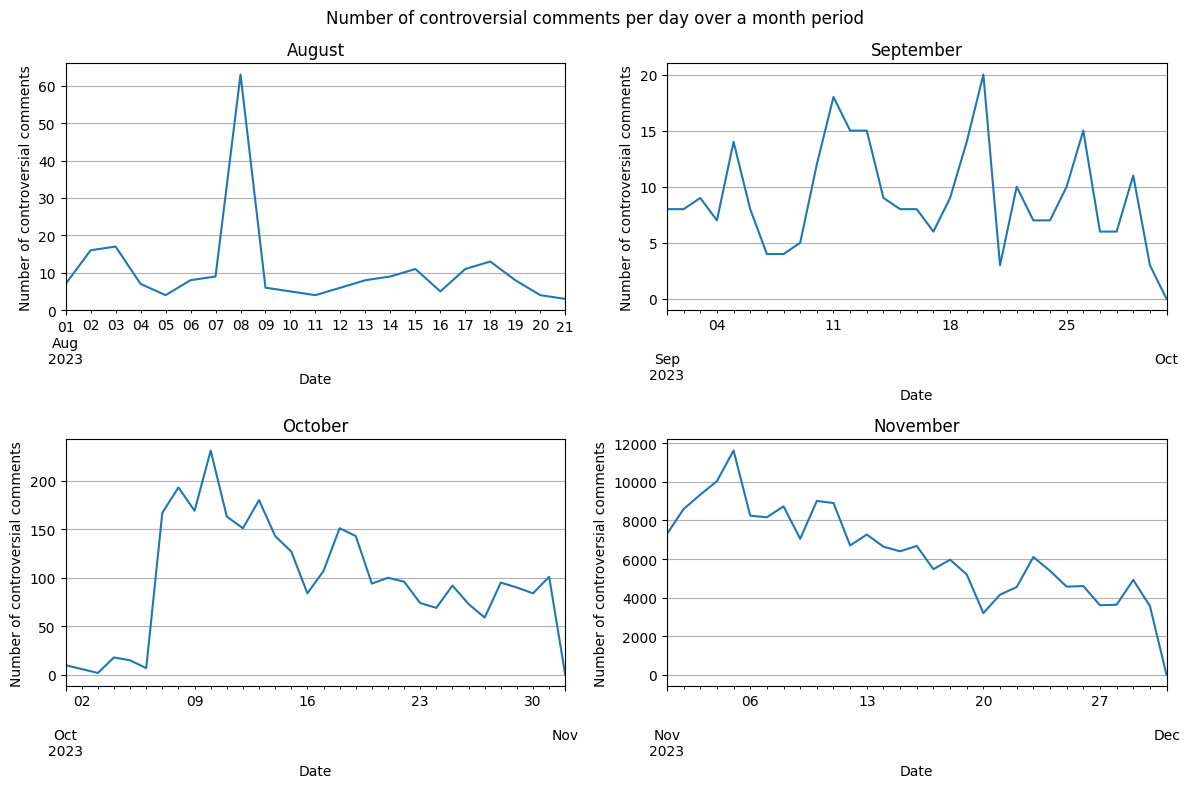

In [ ]:
all_comments = [comments_8, comments_9, comments_10, comments_11]

month_names = ['August', 'September', 'October', 'November']

# Create a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Number of controversial comments per day over a month period')

for i, df in enumerate(all_comments):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    newdf = df.set_index('timestamp', inplace=False)
    # Resample the data to get counts of controversy per time period (here we take per day)
    controversy_counts = newdf['controversial'].resample('D').sum()
    # find appropriate subplot
    ax = axs[i // 2, i % 2]
    controversy_counts.plot(ax=ax)
    ax.set_title(f'{month_names[i]}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of controversial comments')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


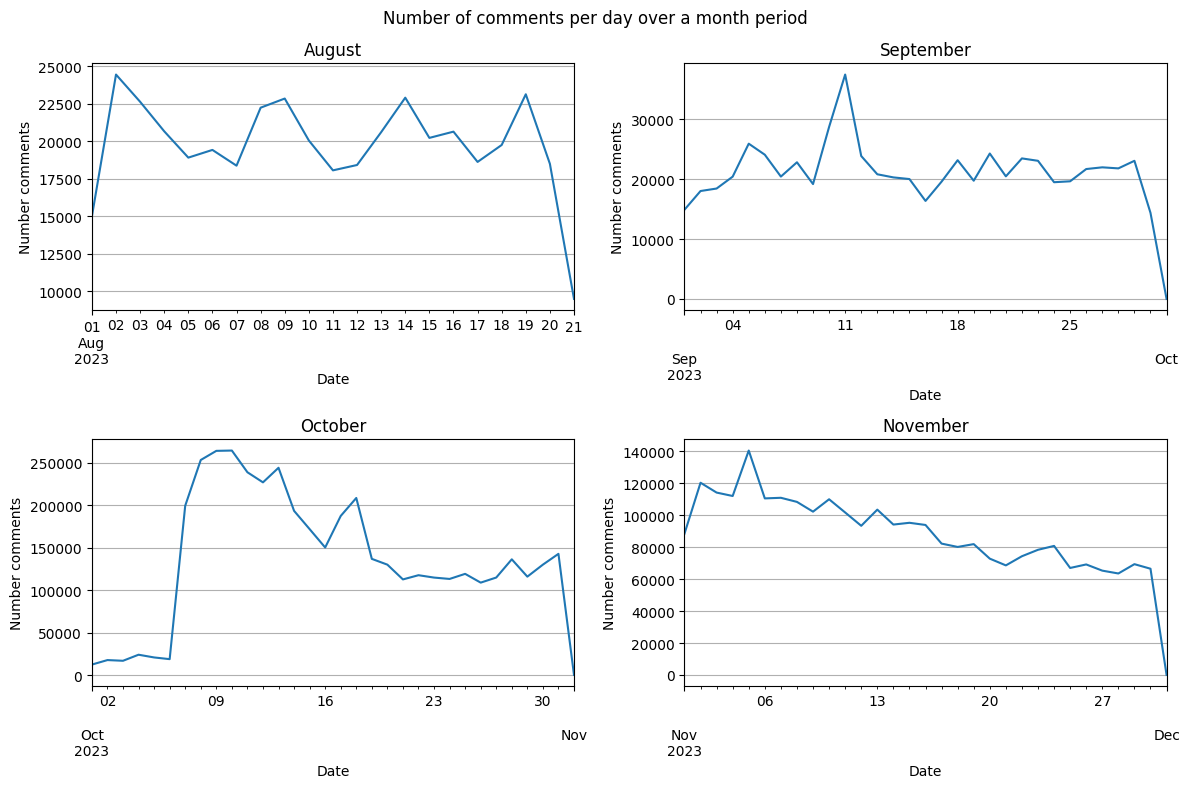

In [ ]:
# Create a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Number of comments per day over a month period')

for i, df in enumerate(all_comments):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    newdf = df.set_index('timestamp', inplace=False)
    # Resample the data to get counts of controversy per time period (here we take per day)
    controversy_counts = newdf['controversial'].resample('D').count()
    # find appropriate subplot
    ax = axs[i // 2, i % 2]
    controversy_counts.plot(ax=ax)
    ax.set_title(f'{month_names[i]}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number comments')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


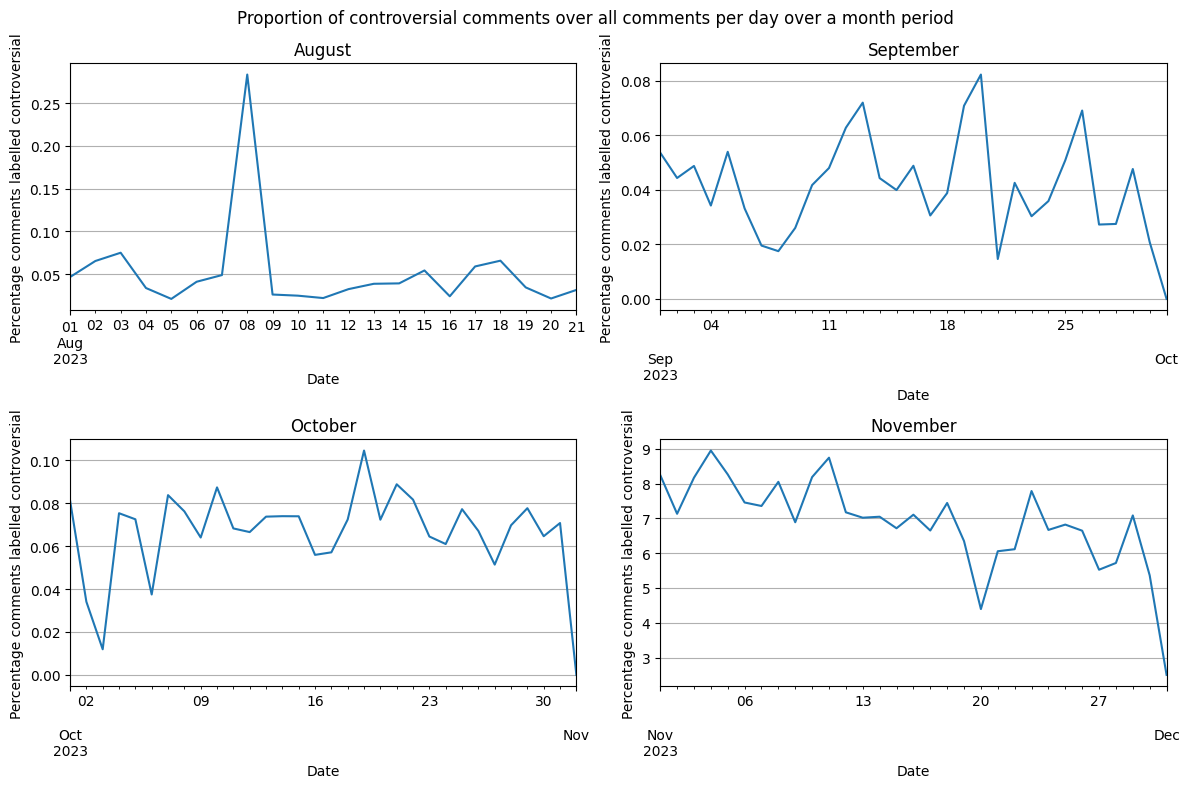

In [ ]:
# Create a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Proportion of controversial comments over all comments per day over a month period')

for i, df in enumerate(all_comments):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    newdf = df.set_index('timestamp', inplace=False)
    # Resample the data to get counts of controversy per time period (here we take per day)
    controversy_counts =100*newdf['controversial'].resample('D').sum() / newdf['controversial'].resample('D').count()
    # find appropriate subplot
    ax = axs[i // 2, i % 2]
    controversy_counts.plot(ax=ax)
    ax.set_title(f'{month_names[i]}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Percentage comments labelled controversial')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## Controversial comment classification 

In this section, we will build a simple classifier to predict the controversial comments based on text only. We will first train on the sample dataset and evaluate on different month periods.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

### Prepare the data

#### (1) Class-balanced data

In [ ]:
total_comments = len(comments_8) + len(comments_9) + len(comments_10) + len(comments_11)

In [ ]:
total_comments

8089095

In [ ]:
len(comments_8) * 100 / total_comments + len(comments_9) * 100 / total_comments + len(comments_10) * 100 / total_comments + len(comments_11) * 100 / total_comments

100.0

In [ ]:
df8 = comments_8[comments_8['controversial'] == 0].sample(n=int(len(comments_8) * 1000 / total_comments))
df8_cont = comments_8[comments_8['controversial'] == 1].sample(n=int(len(comments_8) * 1000 / total_comments))
df9 = comments_9[comments_9['controversial'] == 0].sample(n=int(len(comments_9) * 1000 / total_comments))
df9_cont = comments_9[comments_9['controversial'] == 1].sample(n=int(len(comments_9) * 1000 / total_comments))
df10 = comments_10[comments_10['controversial'] == 0].sample(n=int(len(comments_10) * 1000 / total_comments))
df10_cont = comments_10[comments_10['controversial'] == 1].sample(n=int(len(comments_10) * 1000 / total_comments))

df11 = comments_11[comments_11['controversial'] == 0].sample(n=int(len(comments_11) * 1000 / total_comments))
df11_cont = comments_11[comments_11['controversial'] == 1].sample(n=int(len(comments_11) * 1000 / total_comments))


In [ ]:
len(comments_8) * 1000 / total_comments

51.27644068959506

In [ ]:
frames = [df8, df8_cont, df9, df9_cont, df10, df10_cont, df11, df11_cont]


train_test_val_df = pd.concat(frames)

In [ ]:
train_test_val_df.drop(['subreddit', 'id', 'author', 'timestamp', 'submission_id', 'score', 'ups', 'downs',  'parent_id'], inplace=True, axis=1)

In [ ]:
train_test_val_df.head()

text  controversial
295515                                          [deleted]              0
63159   all the religious people tell me atheism is sc...              0
157515  there is nothing you can say that will stop me...              0
24349                              france based, you mean              0
273266  > why should israel give citizenship to people...              0

In [ ]:
# Shuffle the dataset and split between train:val:test using a 70:10:20 ratio
train_test_val_df = train_test_val_df.sample(frac = 1)
train_df = train_test_val_df.iloc[:1398,:]
val_df = train_test_val_df.iloc[1398:1598,:]
test_df = train_test_val_df.iloc[1598:,:]

#### (2) Define a custom dataset class

In [ ]:
# Define RedditDataset 

class RedditDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.texts = dataframe["text"]
        self.labels = dataframe["controversial"]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
            text = str(self.texts.iloc[idx])
            text = " ".join(text.split())
            label = self.labels.iloc[idx]

            # Tokenize text
            #inputs = self.tokenizer(
            #    text,
            #    max_length=self.max_length,
            #    padding="max_length",
            #    truncation=True,
            #    return_tensors="pt"
            #)
            inputs = self.tokenizer.encode_plus(
                text,
                None,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                return_token_type_ids=True,
                return_tensors="pt"
            )

            ids = inputs["input_ids"]
            mask = inputs["attention_mask"]
            token_type_ids = inputs["token_type_ids"]


            output = {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'labels' : torch.tensor(label, dtype=torch.float),
            }

            #input_ids = inputs["input_ids"].squeeze(0)
            #attention_mask = inputs["attention_mask"].squeeze(0)

            return output

In [ ]:
# Load DistilBert tokenizer

from transformers import AutoTokenizer, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

#tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [ ]:
# create the dataloaders for train, test and validation datasets

train_dataset = RedditDataset(train_df, tokenizer)
test_dataset = RedditDataset(test_df, tokenizer)
val_dataset = RedditDataset(val_df, tokenizer)

In [ ]:
train_dataset[0]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_79282/396020171.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'ids': torch.tensor(ids, dtype=torch.long),
/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_79282/396020171.py:44: UserWarning: To copy construct from a

{'ids': tensor([[ 101, 2027, 1005, 2128, 2025, 4286, 1012,  102,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         

#### (3) Dataloader class

In [ ]:
# common variables 
MAX_LENGTH = 512
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42
DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2

# Training params
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05
NUM_WORKERS = 1

In [ ]:
from torch.utils.data import DataLoader

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': NUM_WORKERS
                }

training_loader = DataLoader(train_dataset, **train_params)

### Model and Training Architecture

#### (1) Model class

In [ ]:
from transformers import DistilBertModel

class DistilBERTClass(torch.nn.Module):
    
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
#from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

#model = AutoModelForSequenceClassification.from_pretrained(
#    "distilbert/distilbert-base-uncased", num_labels=1)

In [ ]:
device = torch.device('cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA")

model = DistilBERTClass()
model.to(device)

Using MPS


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [ ]:
model

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

#### (2) Loss function and Optimizer

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

#### (3) Evaluation 

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy_result = accuracy.compute(predictions=predictions, references=labels)
    precision_result = precision.compute(predictions=predictions, references=labels)
    recall_result = recall.compute(predictions=predictions, references=labels)
    f1_result = f1.compute(predictions=predictions, references=labels)
    
    metrics = {
        "accuracy": accuracy_result["accuracy"],
        "precision": precision_result["precision"],
        "recall": recall_result["recall"],
        "f1": f1_result["f1"]
    }
    
    return metrics


### Training Loop

In [ ]:
import tqdm
import wandb

wandb.init(project="contov-class")


def train(model, dataloader, criterion, num_epochs=EPOCHS):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        print(f"Starting epoch {epoch + 1}")
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        
        # Log metrics to wandb
        wandb.log({"epoch": epoch + 1, "loss": avg_loss})
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Save model checkpoint
        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
        wandb.save(f"model_epoch_{epoch + 1}.pth")

    # Finish the run
    wandb.finish()


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [ ]:
# Run training 
criterion = loss_fn

train(model, training_loader, criterion, EPOCHS)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'RedditDataset' on <module '__main__' (built-in)>
wandb: Network error (ConnectionError), entering retry loop.


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
training_args = TrainingArguments(
    output_dir="controv_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    #push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: celia-nouri (celiadev). Use `wandb login --relogin` to force relogin


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Checkpoint destination directory controv_classifier/checkpoint-100 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.2226332277059555, 'eval_accuracy': 0.5275, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 9.1771, 'eval_samples_per_second': 43.587, 'eval_steps_per_second': 2.724, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Checkpoint destination directory controv_classifier/checkpoint-200 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.22988325357437134, 'eval_accuracy': 0.5275, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 8.7448, 'eval_samples_per_second': 45.741, 'eval_steps_per_second': 2.859, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.256645143032074, 'eval_accuracy': 0.5275, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 8.8135, 'eval_samples_per_second': 45.385, 'eval_steps_per_second': 2.837, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.27766484022140503, 'eval_accuracy': 0.5275, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 8.8176, 'eval_samples_per_second': 45.364, 'eval_steps_per_second': 2.835, 'epoch': 4.0}
{'loss': 0.1433, 'grad_norm': 2.200226068496704, 'learning_rate': 1e-05, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.27655869722366333, 'eval_accuracy': 0.5275, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 8.7616, 'eval_samples_per_second': 45.654, 'eval_steps_per_second': 2.853, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.27985814213752747, 'eval_accuracy': 0.5275, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 8.6737, 'eval_samples_per_second': 46.116, 'eval_steps_per_second': 2.882, 'epoch': 6.0}


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2886117696762085, 'eval_accuracy': 0.5275, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 8.8107, 'eval_samples_per_second': 45.399, 'eval_steps_per_second': 2.837, 'epoch': 7.0}


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2883298397064209, 'eval_accuracy': 0.5275, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 8.7869, 'eval_samples_per_second': 45.522, 'eval_steps_per_second': 2.845, 'epoch': 8.0}


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2907702624797821, 'eval_accuracy': 0.5275, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 8.7798, 'eval_samples_per_second': 45.559, 'eval_steps_per_second': 2.847, 'epoch': 9.0}
{'loss': 0.0147, 'grad_norm': 0.9164776802062988, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2889859080314636, 'eval_accuracy': 0.5275, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 8.6962, 'eval_samples_per_second': 45.997, 'eval_steps_per_second': 2.875, 'epoch': 10.0}
{'train_runtime': 1258.5753, 'train_samples_per_second': 12.697, 'train_steps_per_second': 0.795, 'train_loss': 0.07900621271133423, 'epoch': 10.0}


TrainOutput(global_step=1000, training_loss=0.07900621271133423, metrics={'train_runtime': 1258.5753, 'train_samples_per_second': 12.697, 'train_steps_per_second': 0.795, 'train_loss': 0.07900621271133423, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

  0%|          | 0/25 [00:00<?, ?it/s]

/Users/celianouri/anaconda3/envs/cv-proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2226332277059555,
 'eval_accuracy': 0.5275,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_runtime': 9.6568,
 'eval_samples_per_second': 41.421,
 'eval_steps_per_second': 2.589,
 'epoch': 10.0}

In [ ]:
model.device

device(type='mps', index=0)

In [ ]:
test_texts = []
i = 0

for cont_text in controv_8['text']:
    test_texts += [cont_text]
    i += 1
    if i > 10:
        break

In [ ]:
test_texts

['so were the european settlers in us. are they not american? land changes hands, deal with it.',
 "about 30% aren't religious, which is a lot compared to most countries, but certainly not a majority.source: ",
 'didn’t the ottoman ban the printing press?',
 'you just described another bofe sidez.islam is drunk on double standards.',
 '>but islam has some members who very much will be a threat to national security to stop thisit is sad but true, extremists will always appear and do some horrible shit. hence the threat to national security, sometimes national security can be more important than freedom of speech... especially if that freedom of speech can involuntarily cause harm to innocent bystanders who had nothing to do with it',
 'those are all hyper-local in time and place. they die with the children or grandchildren of the people they were native to. they can\'t genuinely be carried through generations, and people who try to resurrect them are literally larping.it\'s a bit baffli

## Inference

In [ ]:
text = controv_8['text'][1215]

def run_inference(text, model):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return predicted_class_id


In [ ]:
preds = []
for t in test_texts:
    pred = run_inference(t, model)
    preds += [pred]


In [ ]:
preds

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
text

'so were the european settlers in us. are they not american? land changes hands, deal with it.'